In [1]:
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats 
from scipy.optimize import curve_fit 

import FunctionsP6 as fc

from mpl_toolkits import mplot3d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.ticker as mticker

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

dpi=300
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import statsmodels.api as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points
lowess = sm.nonparametric.lowess

In [2]:
savepath = os.getcwd()+'/Figures_Thesis/'

# Load Data

In [3]:
'''
We load the data that is prepared in 'M2_DataPrep'
'''
# GSAT, zostoga observations (1900 - 2005) merged with AR6 ranges for all scenarios (2005 - 2100) 
df_low = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv').set_index('Date')
df_mid = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv').set_index('Date')
df_hig = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv').set_index('Date')

# CMIP5 and CMIP6 data (1900 - 2100)
CMIP5ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5.nc')
CMIP6ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6.nc')

CMIP5ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5_LF_25.nc')
CMIP6ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6_LF_25.nc')

# DSL budgets / reanalysis (ora20c)
df_dsl_b1 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b1.csv' ).set_index('time') # (1979 - 2018)
df_dsl_b2 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b2.csv' ).set_index('time') # (1950 - 2020)

# Reanalysis (1905 - 2005) (1990-1994 and 2006-2009 is nan)
DSL_ora20c = xr.open_mfdataset(os.getcwd()+'/data_processed/DSL_ora20c.nc') # 1900 - 2022

'''
Change the reference period to 1900,1950 (or any other period between 1900 - 2009)
'''
ref_st, ref_end = 1900,1950

for dfs in [df_low, df_mid, df_hig]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[ref_st:ref_end].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[ref_st:ref_end].mean()[4]

CMIP5ds = CMIP5ds - CMIP5ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds = CMIP6ds - CMIP6ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')

CMIP5ds_LF = CMIP5ds_LF - CMIP5ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds_LF = CMIP6ds_LF - CMIP6ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')

DSL_ora20c = DSL_ora20c - DSL_ora20c.sel(year=slice(ref_st,ref_end)).mean(dim=['year','member'])

# Functions

In [5]:
def select_models(ds, varx1, varx2, vary, check):
    '''
    Check is either 'model', or 'scenario'
    Find models for which all three variables (zos, gsat, zostoga) are available
    Input is dataset CMIP5ds or CMIP6ds. 
    If you want to check the scenarios per model, already select the model in the input: eg. CMIP5ds.sel(model=mod)
    It returns the model/sce names of models/sces that have data for all three variables and returns the new dataset.
    '''
    
    x1 = ds[varx1].dropna(check,'all')[check].values
    x2 = ds[varx2].dropna(check,'all')[check].values
    y = ds[vary].dropna(check,'all')[check].values
        
    check_list = np.sort(list(set(x1)&set(x2)&set(y)))
    
    if check == 'model':
        ds_new = ds.sel(model=check_list)
        
    elif check == 'scenario':
        ds_new = ds.sel(scenario=check_list)
    
    return check_list, ds_new

In [6]:
select_models(CMIP6ds.sel(time=slice(2050,2100)), 'AMOC26', 'GSAT', 'zos', 'model')[0]

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2-WACCM', 'CMCC-CM2-SR5',
       'CanESM5', 'FGOALS-g3', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorESM2-LM'], dtype='<U13')

# Computations and plots

In [15]:
# Choose which type of CMIP data we want to use (LF or not filtered)
data_5C, data_6C = CMIP5ds_LF, CMIP6ds_LF 

### OVERVIEW PLOT GSAT / GMTSL / AMOC

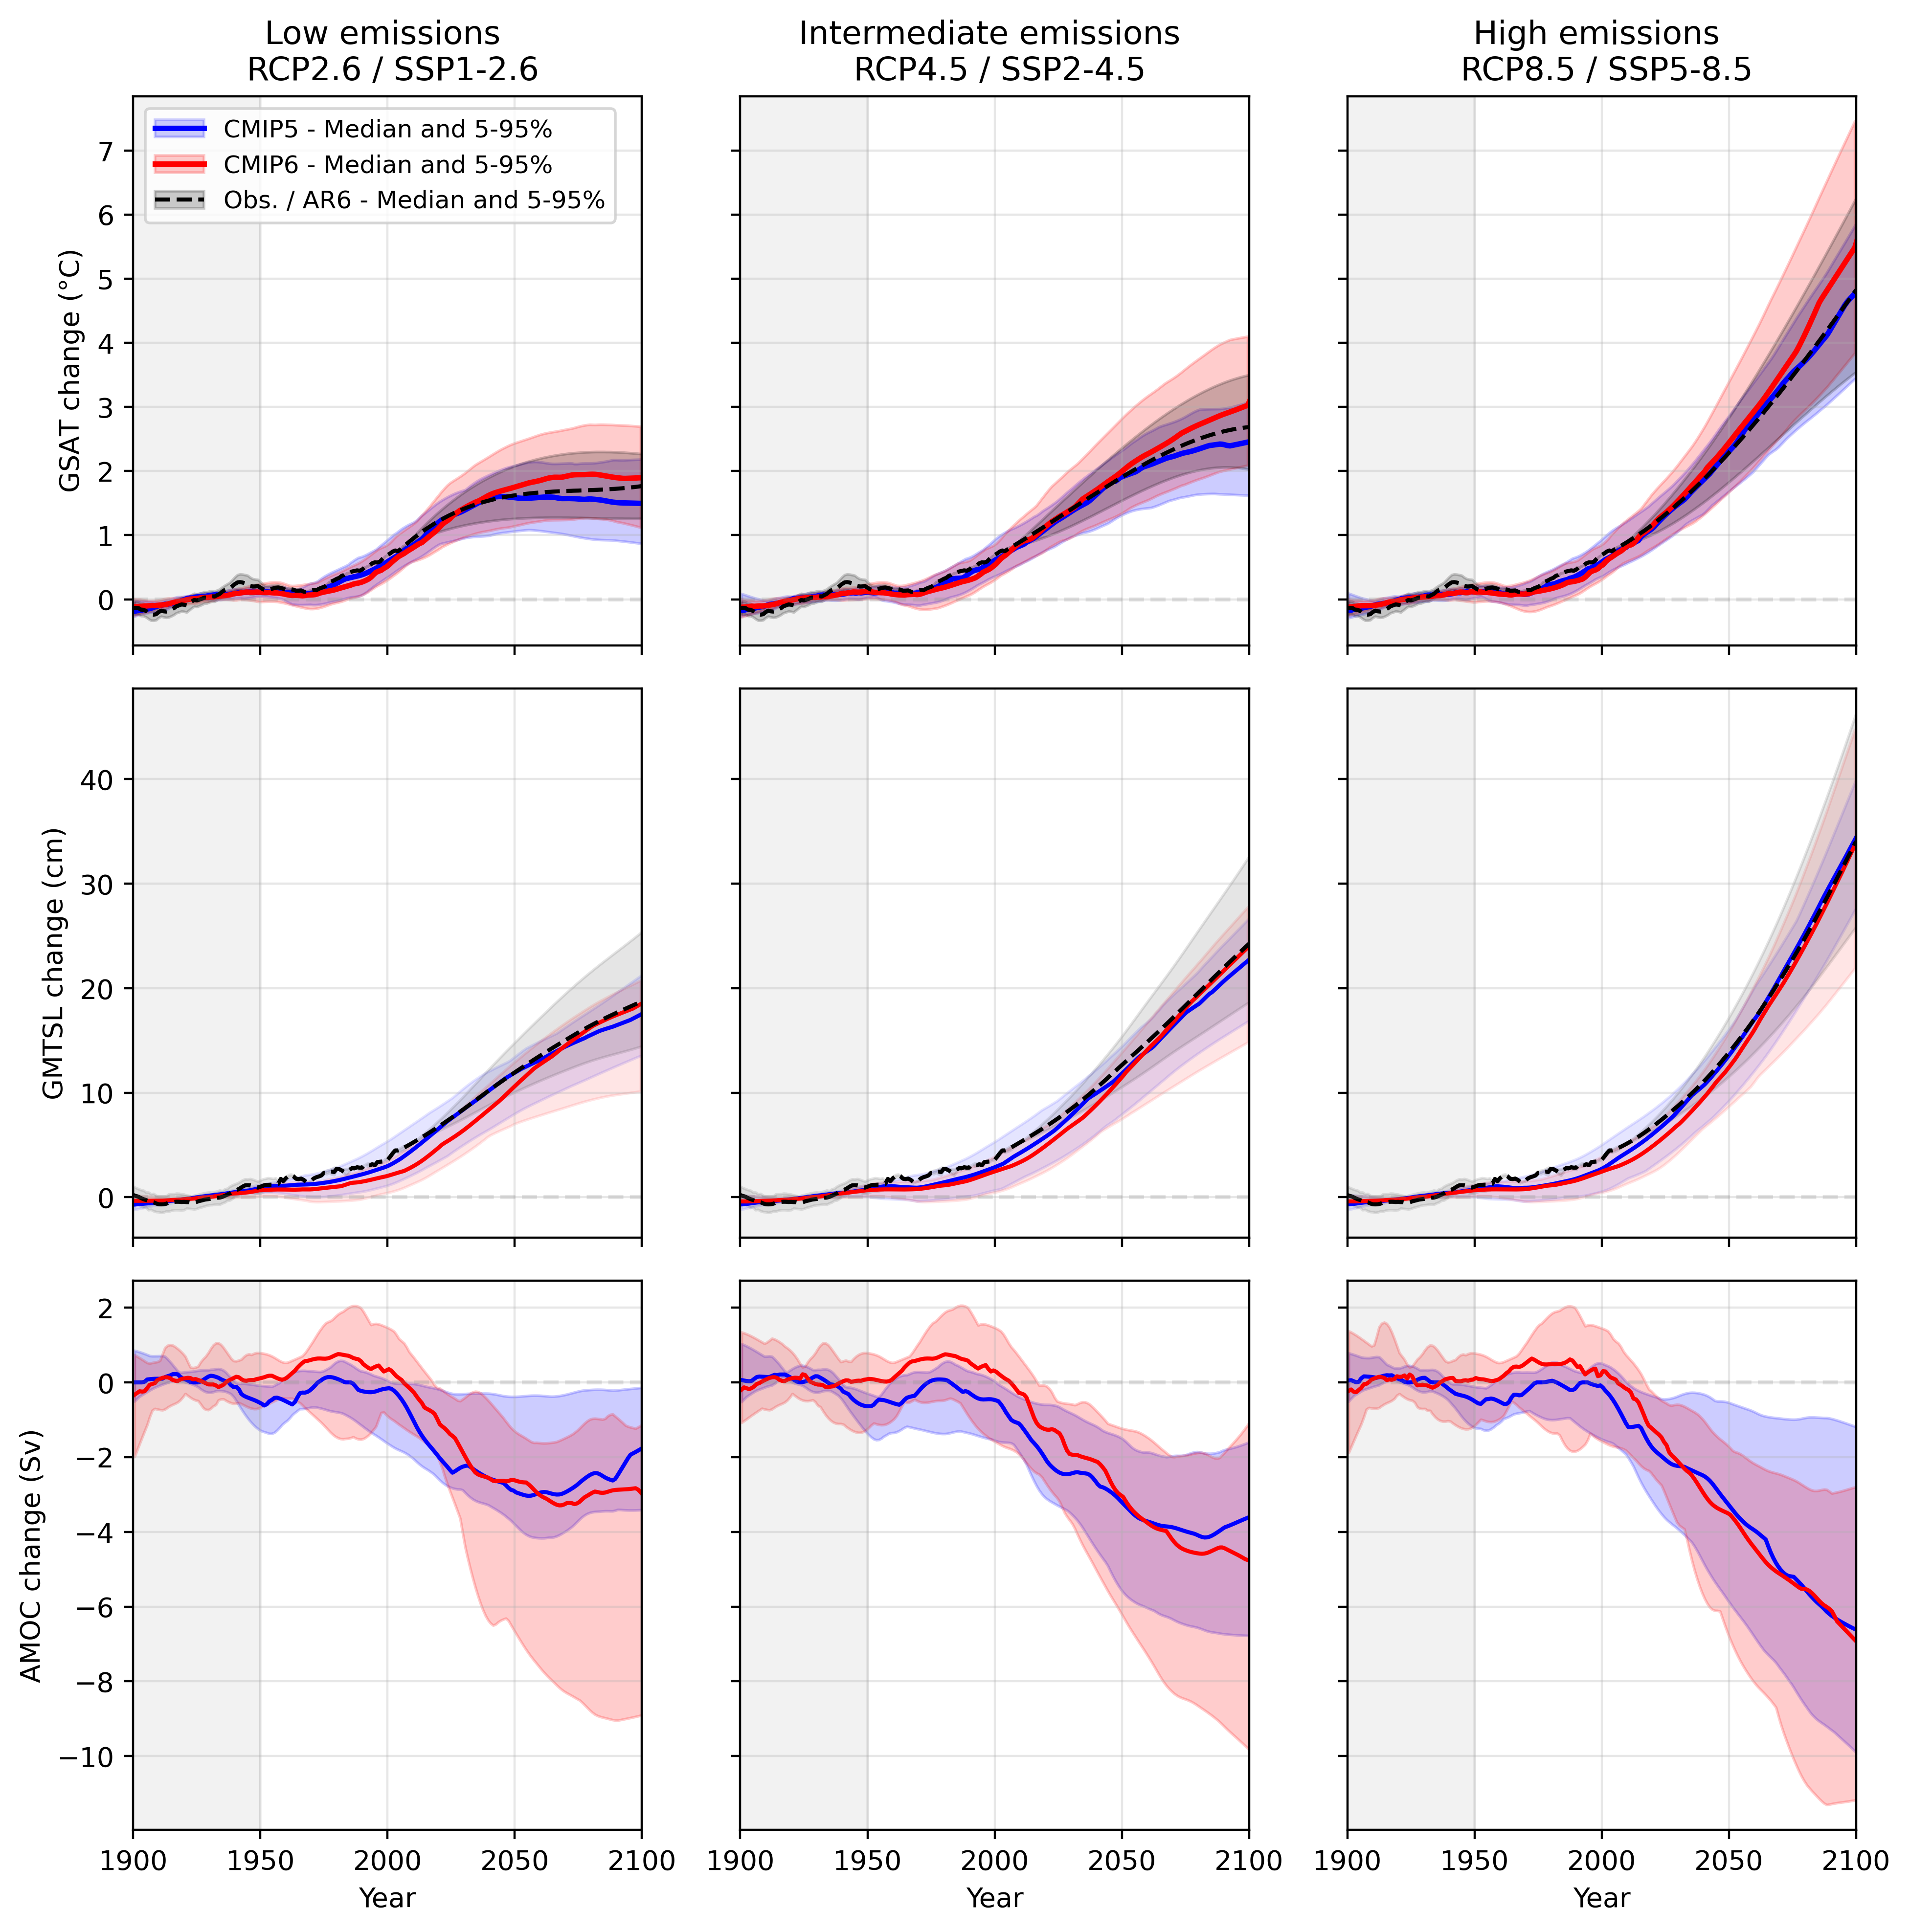

In [125]:
fig,ax = plt.subplots(3,3,figsize=(10,10),dpi=200,sharex=True,sharey='row')
axs = ax.flatten()
c = ['b','r']
sce_mark = ['Low emissions \n RCP2.6 / SSP1-2.6', 'Intermediate emissions \n RCP4.5 / SSP2-4.5', 'High emissions \n RCP8.5 / SSP5-8.5']

# Plot GSAT ax[0:3]
D5i = data_5C.sel(time=slice(1900,2101))
D6i = data_6C.sel(time=slice(1900,2101))
A6 = [df_low, df_mid, df_hig]

for i,sce in enumerate(['ssp126','ssp245','ssp585']):
    D5 = select_models(D5i.sel(scenario=sce), 'zos','GSAT','zos','model')[1]
    D6 = select_models(D6i.sel(scenario=sce), 'zos','GSAT','zos','model')[1]

    D5_d, = axs[i].plot(D5.time.values, D5.GSAT.median(dim='model').values,color=c[0], lw=2,label = 'CMIP5')
    D6_d, = axs[i].plot(D6.time.values, D6.GSAT.median(dim='model').values,color=c[1], lw=2,label = 'CMIP6')
    A6_d, = axs[i].plot(A6[i].index, A6[i]['G_50th'],c='k',ls='dashed',label='AR6')
    
    D5_dd = axs[i].fill_between(D5.time.values, np.percentile(D5.GSAT.values,5,axis=0),
                        np.percentile(D5.GSAT.values,95,axis=0),color=c[0],alpha=0.2)
    D6_dd = axs[i].fill_between(D6.time.values, np.percentile(D6.GSAT.values,5,axis=0),
                        np.percentile(D6.GSAT.values,95,axis=0),color=c[1],alpha=0.2)
    A6_dd = axs[i].fill_between(A6[i].index, A6[i]['G_5th'],
                        A6[i]['G_95th'],alpha=0.2,color='k')

axs[0].set_title(sce_mark[0])
axs[0].set_ylabel(r'GSAT change ($\degree$C)')
axs[1].set_title(sce_mark[1])
axs[2].set_title(sce_mark[2])
axs[0].legend([(D5_d, D5_dd), (D6_d, D6_dd), (A6_d, A6_dd)], 
             [f"CMIP5 - Median and 5-95%",f"CMIP6 - Median and 5-95%",f"Obs. / AR6 - Median and 5-95%"],
             loc=2, fontsize=9)


# Plot GMTSL ax[3:6]
for i,sce in enumerate(['ssp126','ssp245','ssp585']):
    D5 = select_models(D5i.sel(scenario=sce), 'zostoga','GSAT','zos','model')[1]
    D6 = select_models(D6i.sel(scenario=sce), 'zostoga','GSAT','zos','model')[1]

    axs[i+3].fill_between(D5.time.values, np.percentile(D5.zostoga.values,5,axis=0),
                        np.percentile(D5.zostoga.values,95,axis=0),color=c[0],alpha=0.1)
    axs[i+3].fill_between(D6.time.values, np.percentile(D6.zostoga.values,5,axis=0),
                        np.percentile(D6.zostoga.values,95,axis=0),color=c[1],alpha=0.1)
    axs[i+3].fill_between(A6[i].index, A6[i]['z_5th'],
                        A6[i]['z_95th'],alpha=0.1,color='k')

    axs[i+3].plot(D5.time.values, D5.zostoga.median(dim='model').values,color=c[0], label = 'CMIP5')
    axs[i+3].plot(D6.time.values, D6.zostoga.median(dim='model').values,color=c[1], label = 'CMIP6')
    axs[i+3].plot(A6[i].index, A6[i]['z_50th'],c='k',ls='dashed',label='AR6')
    
axs[3].set_ylabel(r'GMTSL change (cm)')


# Plot AMOC ax[6:9]
for i,sce in enumerate(['ssp126','ssp245','ssp585']):
    D5 = select_models(D5i.sel(scenario=sce), 'AMOC26','GSAT','zos','model')[1]
    D6 = select_models(D6i.sel(scenario=sce), 'AMOC26','GSAT','zos','model')[1]
    
    axs[i+6].fill_between(D5.time.values, np.percentile(D5.AMOC26.values,5,axis=0),
                        np.percentile(D5.AMOC26.values,95,axis=0),color=c[0],alpha=0.2)
    axs[i+6].fill_between(D6.time.values, np.percentile(D6.AMOC26.values,5,axis=0),
                        np.percentile(D6.AMOC26.values,95,axis=0),color=c[1],alpha=0.2)

    axs[i+6].plot(D5.time.values, D5.AMOC26.median(dim='model').values,color=c[0], label = 'CMIP5')
    axs[i+6].plot(D6.time.values, D6.AMOC26.median(dim='model').values,color=c[1], label = 'CMIP6')
    axs[i+6].set_xlabel('Year')
    
axs[6].set_ylabel(r'AMOC change (Sv)')

# For all plots:
for axi in axs:
    axi.set_xlim([1900,2100])
    axi.axvspan(1900,1950,alpha=0.1,color='grey')
    axi.axhline(y=0,ls='dashed',c='grey',alpha=0.2)
    axi.grid(True,alpha=0.3)

fig.tight_layout()
fig.savefig(savepath + f'Appendix_Projections.pdf', dpi=dpi)


#### Temporal evolution of ODSL in the North Sea

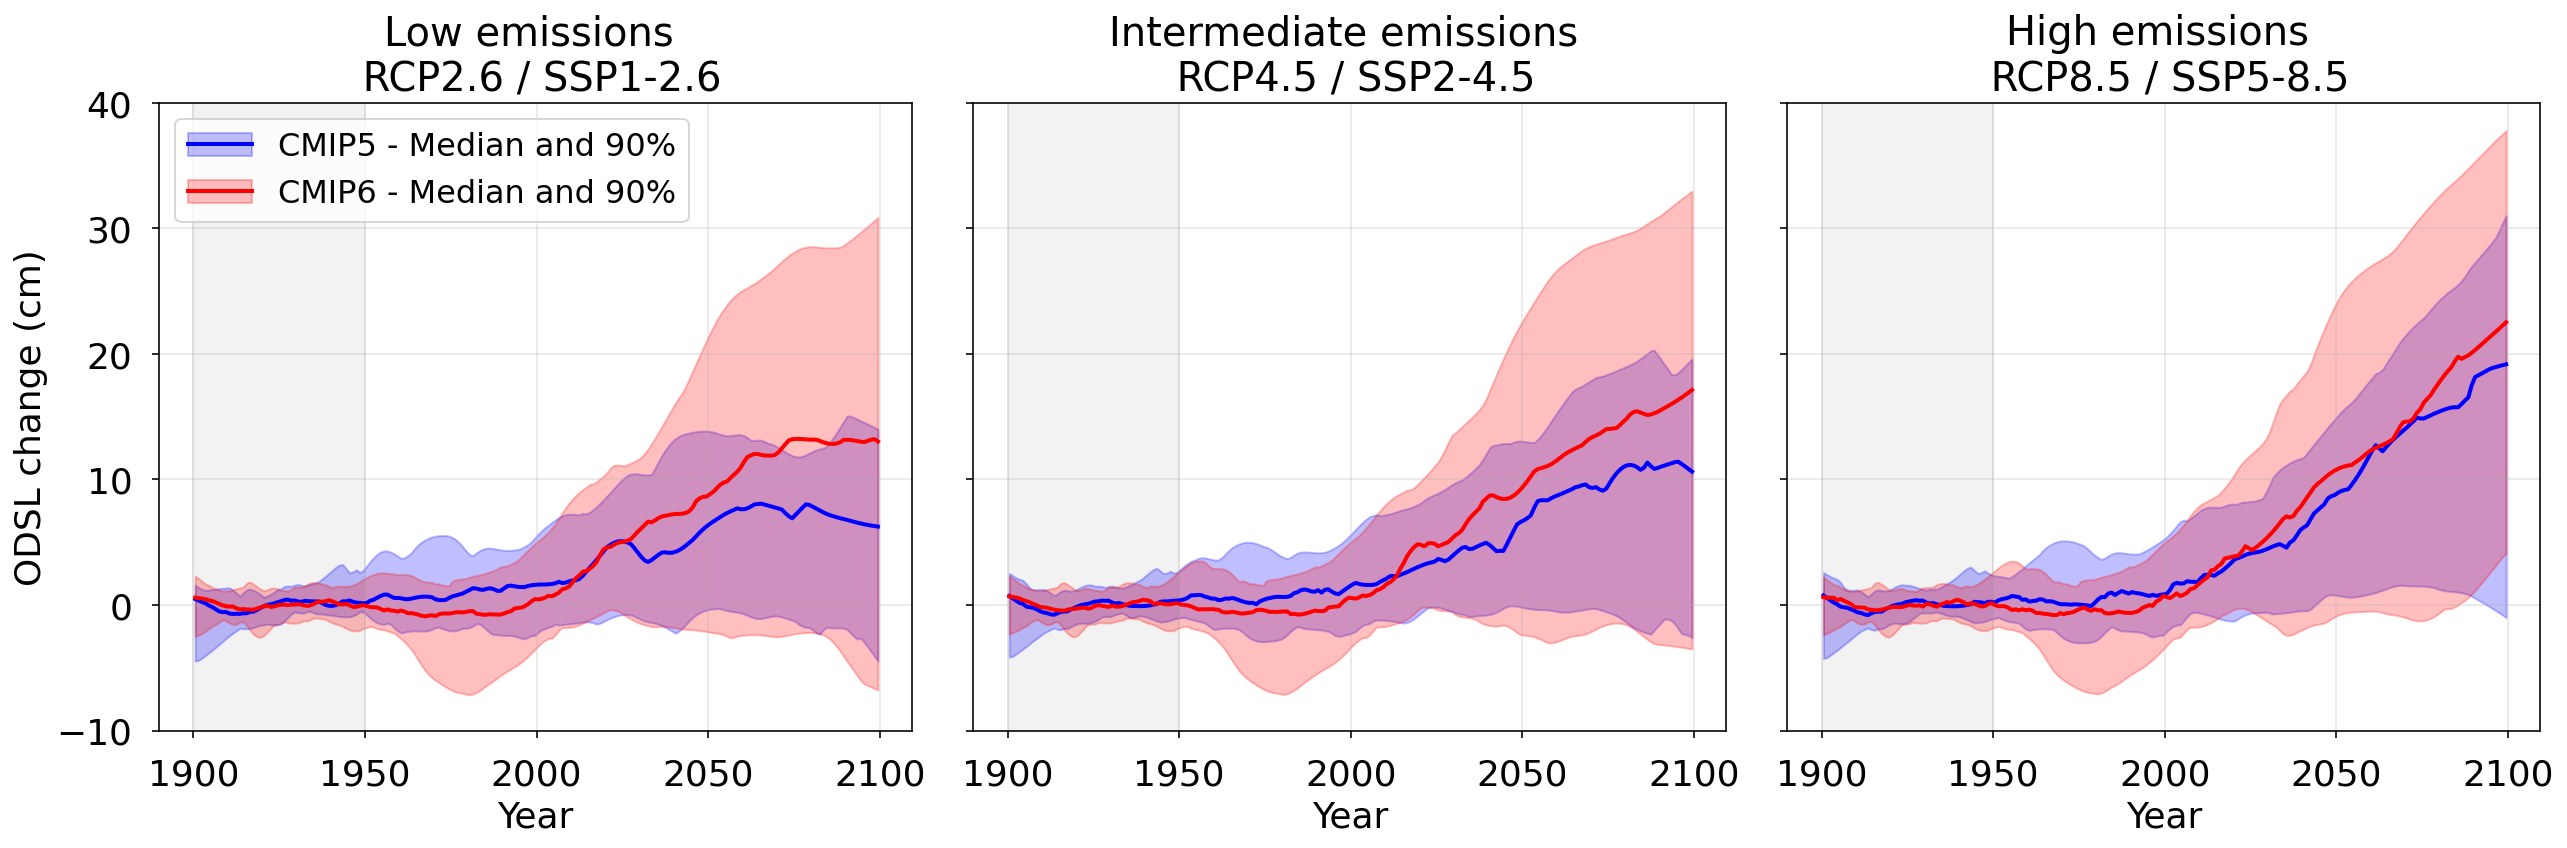

In [95]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey=True)

sces = ['ssp126', 'ssp245', 'ssp585']
sce_mark = ['Low emissions \n RCP2.6 / SSP1-2.6', 'Intermediate emissions \n RCP4.5 / SSP2-4.5', 'High emissions \n RCP8.5 / SSP5-8.5']

ax[0].set_ylabel('ODSL change (cm)', fontsize = 18)


for i, sce in enumerate(sces):
    
    ax[i].axvspan(1900, 1950, alpha=0.1, color='grey')
    ax[i].grid(True,alpha=0.3)

    CMIP5 = select_models(data_5C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
    CMIP6 = select_models(data_6C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
    
    C5, = ax[i].plot(CMIP5.time.values, np.median(CMIP5.zos.values,axis=0), color='blue', label='CMIP5 median',lw=2)
    C6, = ax[i].plot(CMIP6.time.values, np.median(CMIP6.zos.values,axis=0), color='red', label='CMIP6 median',lw=2)

    C55 = ax[i].fill_between(CMIP5.time.values, np.percentile(CMIP5.zos.values,5,axis=0), 
                np.percentile(CMIP5.zos.values,95,axis=0), color='blue',alpha=0.25,
               label='CMIP5, 5-95 percentiles')

    C66 = ax[i].fill_between(CMIP6.time.values, np.percentile(CMIP6.zos.values,5,axis=0), 
                np.percentile(CMIP6.zos.values,95,axis=0), color='red',alpha=0.25,
               label='CMIP6, 5-95 percentiles')
    
    if i == 0:
        ax[0].legend(loc='upper left',fontsize=16)
    
    #ax[i].set_xlim([1900,2100])
    ax[i].set_ylim([-10,40])
    ax[i].set_xlabel('Year', fontsize = 18)
    ax[i].tick_params(axis='x', labelsize= 18)
    ax[i].tick_params(axis='y', labelsize= 18)
    ax[i].set_title(f'{sce_mark[i]}',fontsize=20)
    ax[i].tick_params(axis='both', which='major', pad=10)

    ax[0].legend([(C5, C55), (C6, C66)], 
             [f"CMIP5 - Median and 90%",f"CMIP6 - Median and 90%"],
             loc=2, fontsize=16)
    
fig.tight_layout()
fig.savefig(savepath + f'DSL_CMIP_projections.png', dpi=dpi)

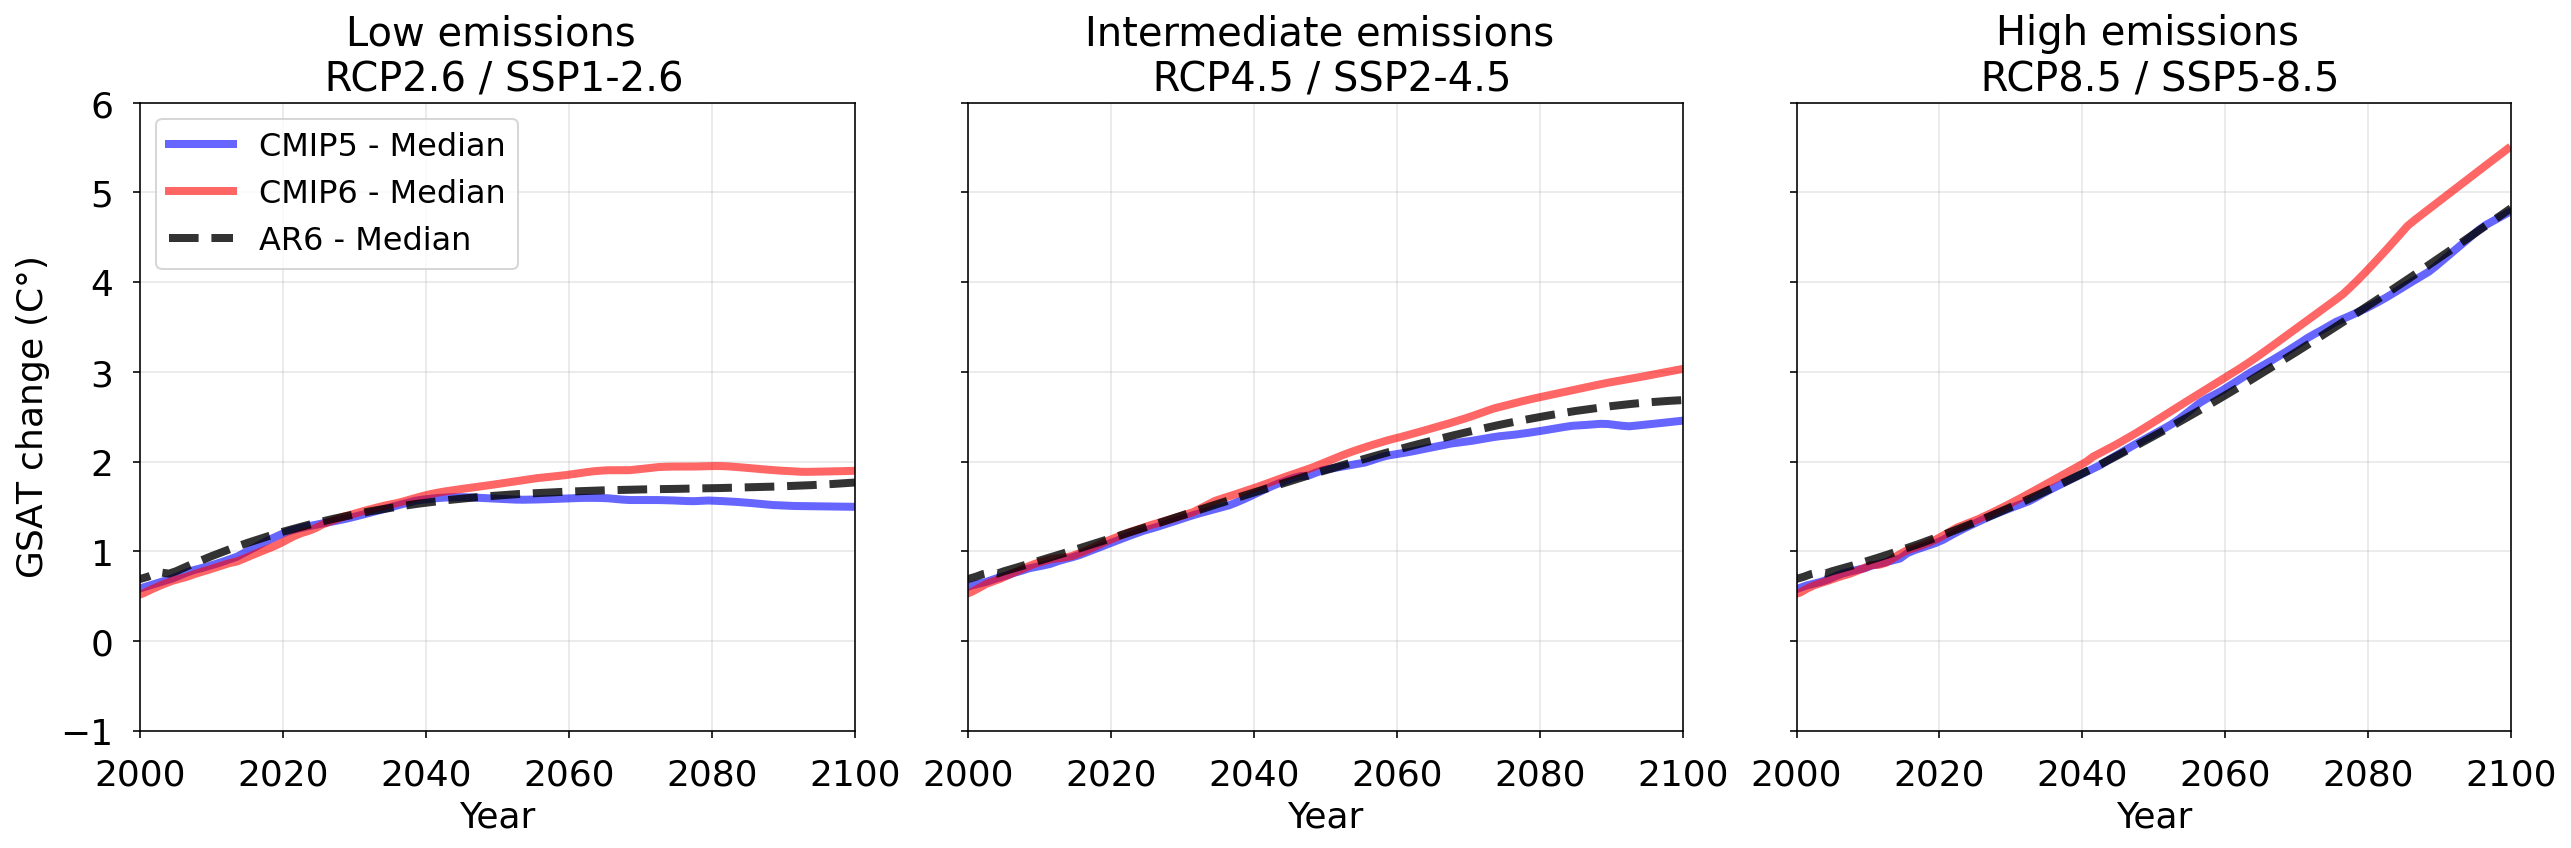

In [15]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey=True)

sces = ['ssp126', 'ssp245', 'ssp585']
sce_mark = ['Low emissions \n RCP2.6 / SSP1-2.6', 'Intermediate emissions \n RCP4.5 / SSP2-4.5', 'High emissions \n RCP8.5 / SSP5-8.5']

ax[0].set_ylabel(r'GSAT change (C$\degree$)', fontsize = 18)

dfs = [df_low, df_mid, df_hig]
for i, sce in enumerate(sces):
    
    ax[i].axvspan(1900, 1950, alpha=0.1, color='grey')
    ax[i].grid(True,alpha=0.3)

    CMIP5 = select_models(data_5C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
    CMIP6 = select_models(data_6C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
    
    C5, = ax[i].plot(CMIP5.time.values, np.median(CMIP5.GSAT.values,axis=0), color='blue', label='CMIP5 median',lw=4,alpha=0.6)
    C6, = ax[i].plot(CMIP6.time.values, np.median(CMIP6.GSAT.values,axis=0), color='red', label='CMIP6 median',lw=4,alpha=0.6)
    df, = ax[i].plot(dfs[i].index, dfs[i]['G_50th'].values,color='k',lw=4,linestyle='dashed',alpha = 0.8)
    
    if i == 0:
        ax[0].legend(loc='upper left',fontsize=16)
    
    ax[i].set_xlim([2000,2100])
    ax[i].set_ylim([-1,6])
    ax[i].set_xlabel('Year', fontsize = 18)
    ax[i].tick_params(axis='x', labelsize= 18)
    ax[i].tick_params(axis='y', labelsize= 18)
    ax[i].set_title(f'{sce_mark[i]}',fontsize=20)
    ax[i].tick_params(axis='both', which='major', pad=10)

    ax[0].legend([(C5), (C6),(df)], 
             [f"CMIP5 - Median",f"CMIP6 - Median","AR6 - Median"],
             loc=2, fontsize=16)
    
fig.tight_layout()
fig.savefig(savepath + f'GSAT_CMIP_projections.png', dpi=dpi)

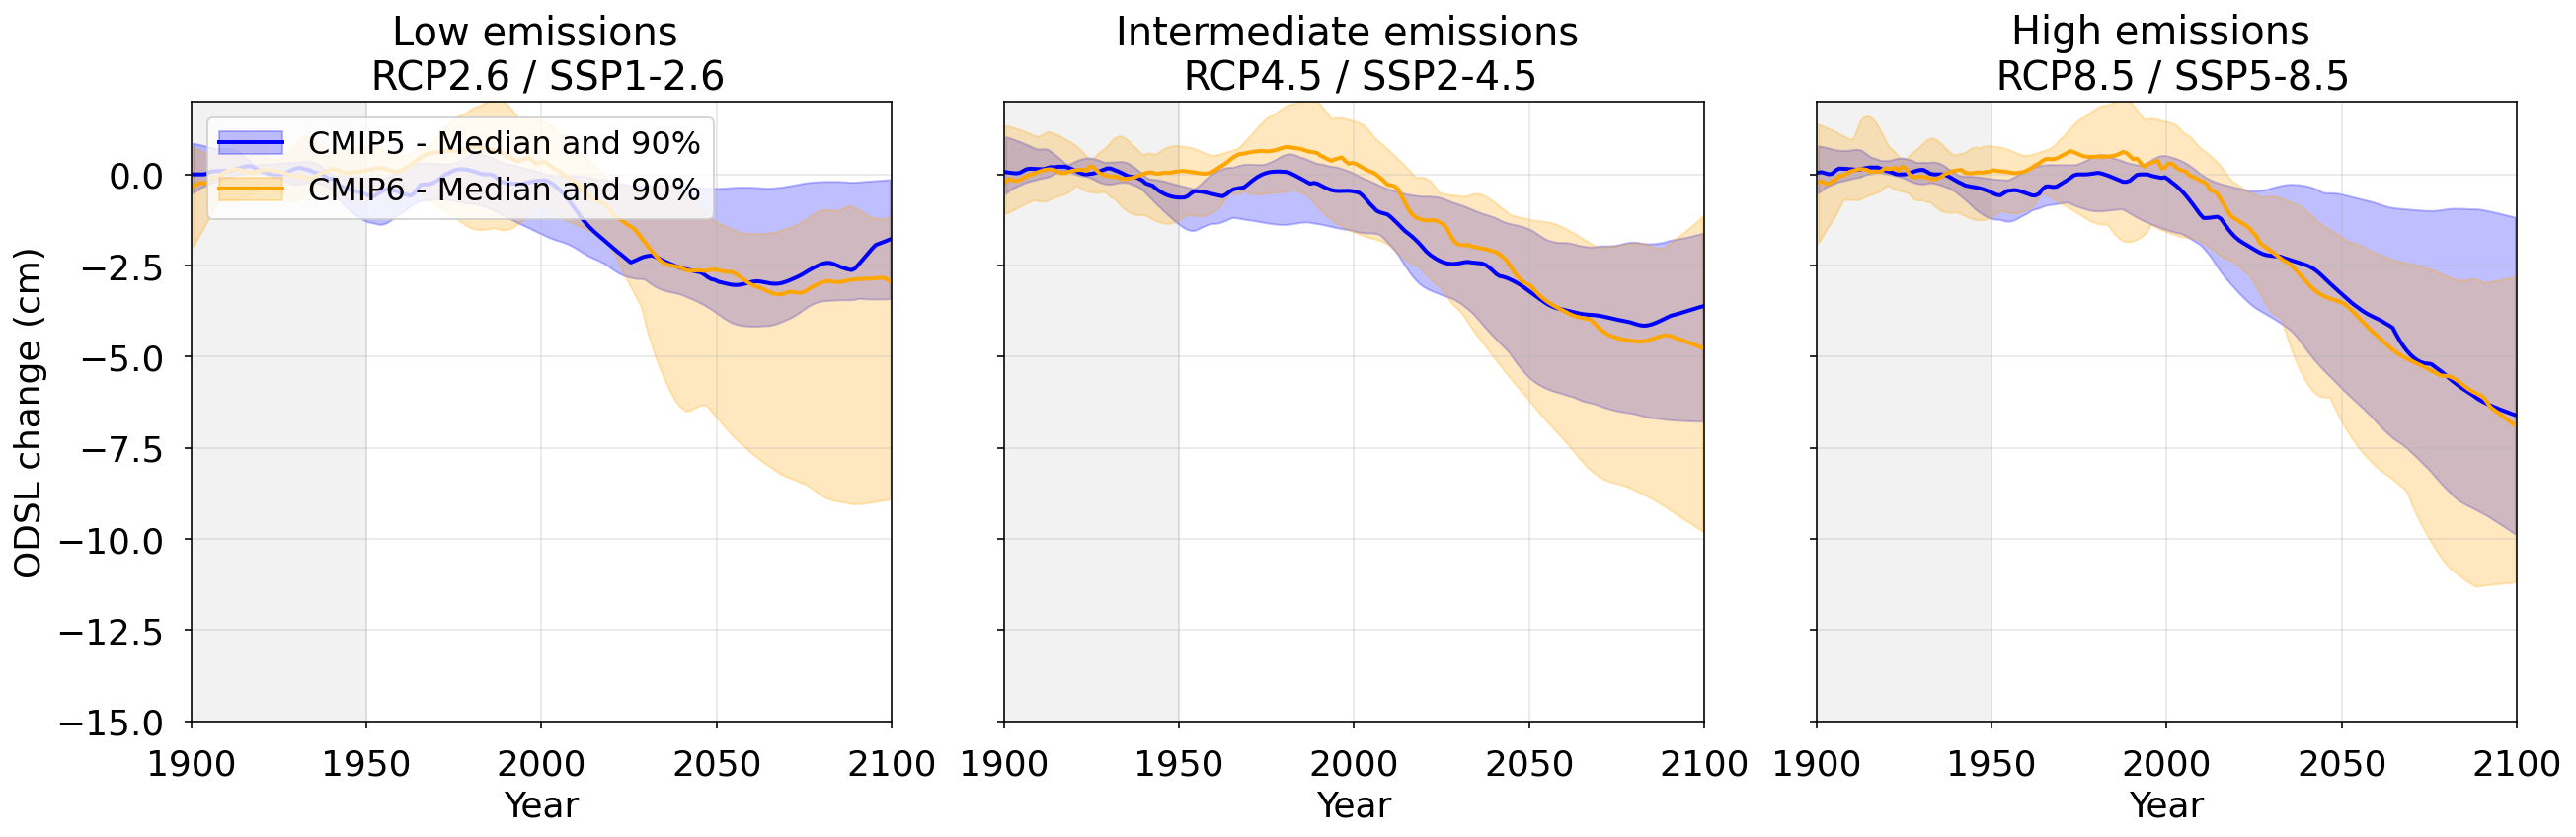

In [16]:
fig, ax = plt.subplots(1,3,figsize=(18,6),sharey=True)

sces = ['ssp126', 'ssp245', 'ssp585']
sce_mark = ['Low emissions \n RCP2.6 / SSP1-2.6', 'Intermediate emissions \n RCP4.5 / SSP2-4.5', 'High emissions \n RCP8.5 / SSP5-8.5']

ax[0].set_ylabel('ODSL change (cm)', fontsize = 18)


for i, sce in enumerate(sces):
    
    ax[i].axvspan(1900, 1950, alpha=0.1, color='grey')
    ax[i].grid(True,alpha=0.3)

    CMIP5 = select_models(data_5C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','AMOC26','zos','model')[1]
    CMIP6 = select_models(data_6C.sel(time=slice(1900,2100),scenario=sce), 'GSAT','AMOC26','zos','model')[1]
    
    C5, = ax[i].plot(CMIP5.time.values, np.median(CMIP5.AMOC26.values,axis=0), color='blue', label='CMIP5 median',lw=2)
    C6, = ax[i].plot(CMIP6.time.values, np.median(CMIP6.AMOC26.values,axis=0), color='orange', label='CMIP6 median',lw=2)

    C55 = ax[i].fill_between(CMIP5.time.values, np.percentile(CMIP5.AMOC26.values,5,axis=0), 
                np.percentile(CMIP5.AMOC26.values,95,axis=0), color='blue',alpha=0.25,
               label='CMIP5, 5-95 percentiles')

    C66 = ax[i].fill_between(CMIP6.time.values, np.percentile(CMIP6.AMOC26.values,5,axis=0), 
                np.percentile(CMIP6.AMOC26.values,95,axis=0), color='orange',alpha=0.25,
               label='CMIP6, 5-95 percentiles')
    
    if i == 0:
        ax[0].legend(loc='upper left',fontsize=16)
    
    ax[i].set_xlim([1900,2100])
    ax[i].set_ylim([-15,2])
    ax[i].set_xlabel('Year', fontsize = 18)
    ax[i].tick_params(axis='x', labelsize= 18)
    ax[i].tick_params(axis='y', labelsize= 18)
    ax[i].set_title(f'{sce_mark[i]}',fontsize=20)
    ax[i].tick_params(axis='both', which='major', pad=10)

    ax[0].legend([(C5, C55), (C6, C66)], 
             [f"CMIP5 - Median and 90%",f"CMIP6 - Median and 90%"],
             loc=2, fontsize=16)
    
fig.tight_layout()
fig.savefig(savepath + f'AMOC26_CMIP_projections.png', dpi=dpi)

## REANALYSIS AND BUDGETS ODSL

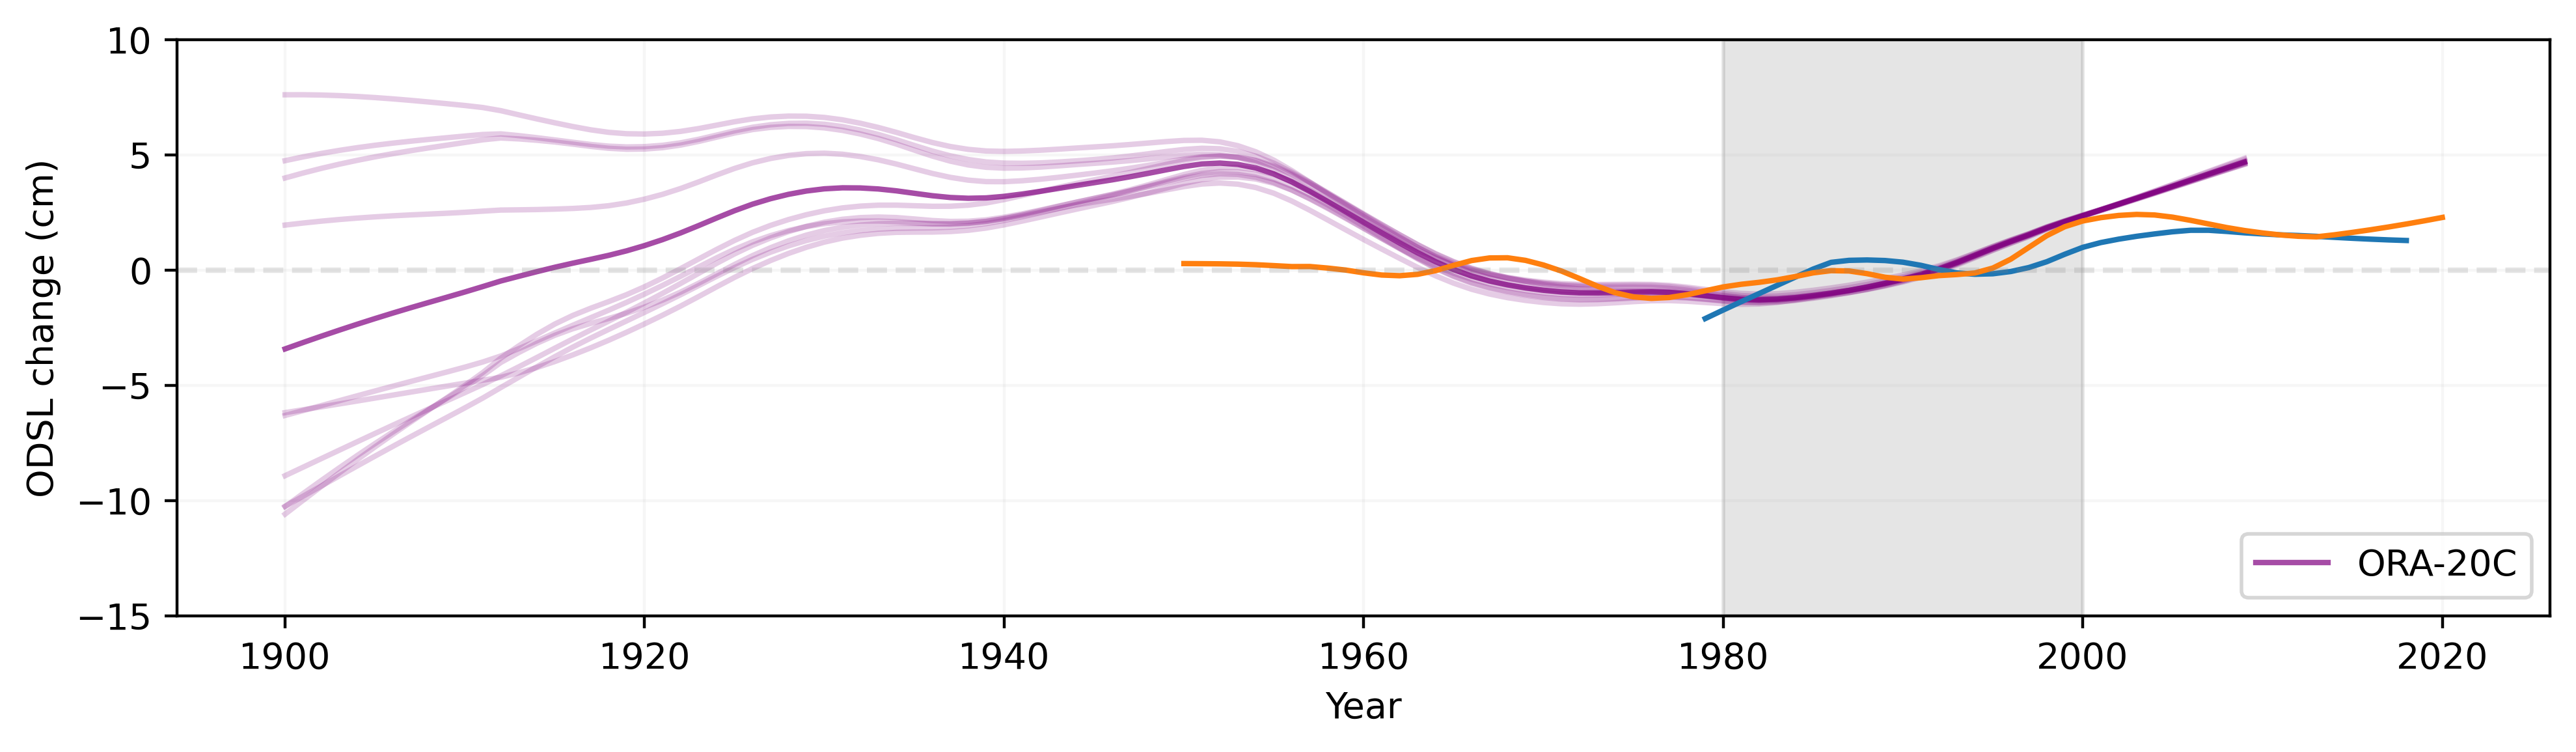

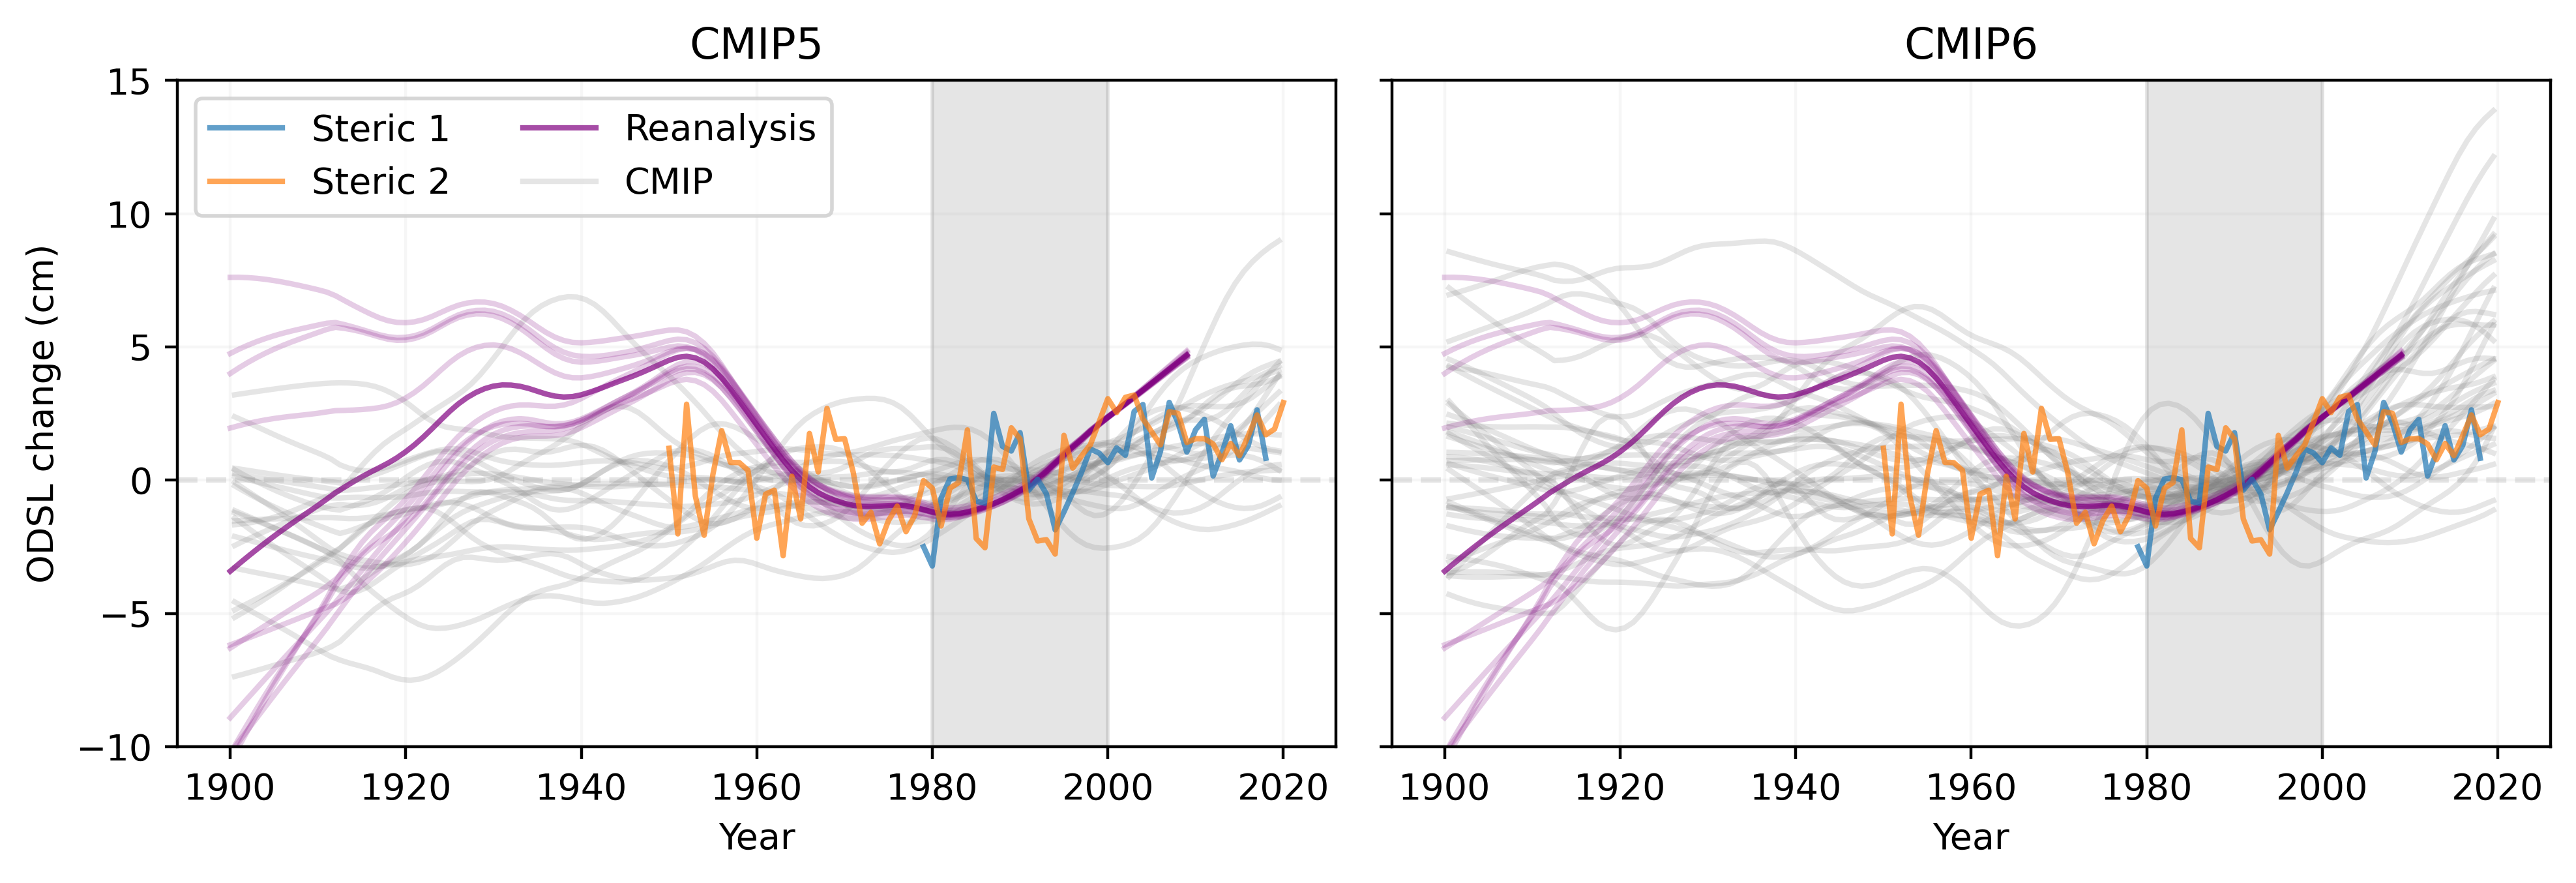

In [14]:
strt_yr_obs,end_yr_obs = 1980,2000
DSL_B1 = df_dsl_b1 - df_dsl_b1.loc[strt_yr_obs:end_yr_obs].mean()
DSL_B2 = df_dsl_b2 - df_dsl_b2.loc[strt_yr_obs:end_yr_obs].mean()
DSL_ORA = DSL_ora20c - DSL_ora20c.sel(year=slice(strt_yr_obs,end_yr_obs)).mean(dim=['year','member'])
DSL_C5_OBS = CMIP5ds_LF - CMIP5ds_LF.sel(time=slice(strt_yr_obs,end_yr_obs)).mean(dim='time')
DSL_C6_OBS = CMIP6ds_LF - CMIP6ds_LF.sel(time=slice(strt_yr_obs,end_yr_obs)).mean(dim='time')
DSL_C5_OBS = DSL_C5_OBS.sel(time=slice(1900,2020))
DSL_C6_OBS = DSL_C6_OBS.sel(time=slice(1900,2020))


fig, ax = plt.subplots(1,1,figsize=(10,3),dpi=200)


for membs in DSL_ORA.member.values:
    ax.plot(DSL_ORA.year.values,DSL_ORA.sel(member=membs).LF_zos.values,c='purple',alpha=0.2)
ax.plot(DSL_ORA.year.values,DSL_ORA.LF_zos.mean(dim='member').values,c='purple',label='ORA-20C',alpha=0.7)
#ax.plot(DSL_ORA.year.values,DSL_ORA.zos.mean(dim='member').values,c='purple',label='ORA-20C',alpha=0.7)

#ax.plot(DSL_B1,label='Budget1',alpha=0.7)
#ax.plot(DSL_B2,label='Budget2',alpha=0.7)
fracb1 = 15/DSL_B1.index.values.shape[0]
fracb2 = 15/DSL_B2.index.values.shape[0]

ax.plot(DSL_B1.index.values,lowess(DSL_B1.values.T[0], DSL_B1.index.values,fracb1,return_sorted=False))
ax.plot(DSL_B2.index.values,lowess(DSL_B2.values.T[0], DSL_B2.index.values,fracb2,return_sorted=False))

ax.set_ylabel('ODSL change (cm)')
ax.set_xlabel('Year')

ax.legend(loc='lower right')
ax.axvspan(strt_yr_obs,end_yr_obs,alpha=0.2,color='grey')
ax.axhline(y=0,ls='dashed',c='grey',alpha=0.2)
ax.grid(True,alpha=0.1)
#ax.tick_params(axis='both', which='major', pad=10)
ax.set_ylim([-15,10])
fig.tight_layout()
fig.savefig(savepath+'DSL_OBS.png',dpi=dpi)



# Compare with CMIP5 and CMIP6

fig,ax=plt.subplots(1,2,figsize=(10,3.5),dpi=200,sharey=True)
for mods in DSL_C5_OBS.model.values:
    CM_OBS = DSL_C5_OBS.sel(scenario='ssp126', model=mods).zos
    #CM_OBS_LF = lowess(CM_OBS.values,CM_OBS.time.values, 15/len(CM_OBS.time.values),return_sorted=False)
    CM, = ax[0].plot(DSL_C5_OBS.time.values,CM_OBS,
                     c='grey',alpha=0.2,label='CMIP')
    #CM, = ax[0].plot(DSL_C5_OBS.time.values,DSL_C5_OBS.sel(scenario='ssp126', model=mods).zos.values,
    #                 c='grey',alpha=0.2,label='CMIP')

for mods in DSL_C6_OBS.model.values:
    CM_OBS = DSL_C6_OBS.sel(scenario='ssp126', model=mods).zos
    #CM_OBS_LF = lowess(CM_OBS.values,CM_OBS.time.values, 15/len(CM_OBS.time.values),return_sorted=False)
    CM, = ax[1].plot(DSL_C6_OBS.time.values,CM_OBS,
                     c='grey',alpha=0.2,label='CMIP')
    
    #CM, = ax[1].plot(DSL_C6_OBS.time.values,DSL_C6_OBS.sel(scenario='ssp126', model=mods).zos.values,
    #                 c='grey',alpha=0.2,label='CMIP')
ax[0].set_ylabel('ODSL change (cm)')
ax[0].set_title('CMIP5')
ax[1].set_title('CMIP6')

ORA_mems = []
for axs in ax:  
    for membs in DSL_ORA.member.values:
        axs.plot(DSL_ORA.year.values,DSL_ORA.sel(member=membs).LF_zos.values,c='purple',alpha=0.2)
        #axs.plot(DSL_ORA.year.values,ORA_mem_LF,c='purple',alpha=0.2)

    ORA, = axs.plot(DSL_ORA.year.values,DSL_ORA.LF_zos.mean(dim='member').values,c='purple',label='Reanalysis',alpha=0.7)
    #ORA, = axs.plot(DSL_ORA.year.values,np.mean(ORA_mems,axis=0),c='purple',label='Reanalysis',alpha=0.7)

    B1, = axs.plot(DSL_B1,label='Steric 1',alpha=0.7)
    B2, = axs.plot(DSL_B2,label='Steric 2',alpha=0.7)
    #B1, = axs.plot(DSL_B1.index.values,lowess(DSL_B1.values.T[0], DSL_B1.index.values,fracb1,return_sorted=False),lw=2,label='Budget 1',alpha=0.7)
    #B2, = axs.plot(DSL_B2.index.values,lowess(DSL_B2.values.T[0], DSL_B2.index.values,fracb2,return_sorted=False),lw=2,label='Budget 2',alpha=0.7)

    axs.axvspan(strt_yr_obs,end_yr_obs,alpha=0.2,color='grey')
    axs.axhline(y=0,ls='dashed',c='grey',alpha=0.2)
    axs.set_xlabel('Year')
    axs.grid(True,alpha=0.1)
    axs.set_ylim([-10,15])
ax[0].legend(loc='best',handles=[B1, B2, ORA, CM],ncol=2)
fig.tight_layout()
fig.savefig(savepath+'DSL_OBSvsCMIP.pdf',dpi=dpi)


# BAR plots

In [17]:
def edit_scen_name(sce):
    '''Convert name from rcp85 to RCP8.5 and ssp585 to SSP5-8.5'''
    

    if 'rcp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}.{sce[4]}'
    elif 'ssp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}-{sce[4]}.{sce[5]}'
    else:
        print('Scenario name not recognised')
    return sce_out

In [18]:
def make_barplot(ds, mip, perc, start_year, end_year):
    
    # Create Data Frame 
    
    col = [f'{mip.upper()} Scenario']
    for p in perc:
        col.append(f'Percentile: {p}')    
    summary_df = pd.DataFrame(columns=col)
    
    sces = ['ssp126','ssp245','ssp585']
    
    if mip == 'cmip5':
        sces_m = ['rcp26','rcp45','rcp85']
    elif mip == 'cmip6':
        sces_m = sces
    
    for idx,sce in enumerate(sces):
        
        # Check models:
        ds_mods = select_models(ds.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
        print(f'# of models for {sce}, {mip}: {len(ds_mods.model.values)}')
        # Calculate zos, GSAT for time of interest:
        zos = ds_mods.sel(time=slice(start_year, end_year)).mean(dim='time').zos
        #GSAT = ds_mods.sel(time=slice(start_year, end_year)).mean(dim='time').GSAT

        # Append the percentile scores to a list val
        val = [edit_scen_name(sces_m[idx])]
        for p in perc:
            val.append(round(np.quantile(zos.values,p/100),1))
        summary_df.loc[idx] = val
    
    
    summary_df.set_index(col[0], inplace=True)
    summary_df = summary_df.T
        
    return summary_df

In [20]:
start_year, end_year = 2081, 2101

In [23]:
data_5C.sel(time=slice(start_year, end_year )).time.values

array([2081.5, 2082.5, 2083.5, 2084.5, 2085.5, 2086.5, 2087.5, 2088.5,
       2089.5, 2090.5, 2091.5, 2092.5, 2093.5, 2094.5, 2095.5, 2096.5,
       2097.5, 2098.5, 2099.5, 2100.5])

In [21]:
Bar_ds5 = make_barplot(data_5C, 'cmip5', [5,17,50,83,95], start_year, end_year)
Bar_ds6 = make_barplot(data_6C, 'cmip6', [5,17,50,83,95], start_year, end_year)

# of models for ssp126, cmip5: 20
# of models for ssp245, cmip5: 27
# of models for ssp585, cmip5: 25
# of models for ssp126, cmip6: 30
# of models for ssp245, cmip6: 30
# of models for ssp585, cmip6: 31


In [27]:
def summary_fig_and_table(ax, df, colors=None, vlines=False):
    
    mi = 0.6 # Max color intensity
    
    # Get some pastel shades for the colors
    if not(colors):
        colors = plt.cm.Reds(np.linspace(0, mi, len(df.index)))
        rowColours = colors
        
        # Expand the array
        ones = np.ones(len(df.columns))
        colors = colors[np.newaxis,:,:] * ones[:, np.newaxis, np.newaxis]
        
    elif colors=='alternate':
        colors1 = plt.cm.Reds(np.linspace(0, mi, len(df.index)))
        colors2 = plt.cm.Blues(np.linspace(0, mi, len(df.index)))
        colors = np.zeros([len(df.columns), len(df.index), 4])
        colors[::2] = colors2
        colors[1::2] = colors1
        
        rowColours = plt.cm.Greys(np.linspace(0, mi, len(df.index)))

    # Start from white color
    colors[:,0,:] = 0
    
    index = np.arange(len(df.columns))
    bar_width = 0.6

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(df.columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(len(df.index)):
        ax.bar(index, 
               df.iloc[row]-y_offset, 
               bar_width, 
               bottom=y_offset, 
               color=colors[:,row,:])
        
        y_offset = df.iloc[row]
        cell_text.append(['%1.1f' % x for x in df.iloc[row]])
    
    ax.set_xlim(-0.5,index[-1]+0.5)
    ax.set_ylim(-5,40)
    
    # Add a table at the bottom of the axes
    tabel = ax.table(cellText=cell_text[::-1],
             rowLabels=df.index[::-1],
             rowColours=rowColours[::-1],
             colColours=colors[:,2,:],
             colLabels=df.columns,
             loc='bottom')
    #tabel.auto_set_font_size(False)
    #tabel.set_fontsize(18)
    #tabel.scale(2, 2)

    ax.set_xticks([])
    
    if vlines:
        xcoords = index[0:]+1.5
        xcoords = xcoords[::2]
        for xc in xcoords:
            plt.axvline(x=xc, color='black', linewidth=0.5, linestyle='--')
    
    return ax

In [28]:
Bar_ds = pd.concat([Bar_ds5, Bar_ds6], axis=1)

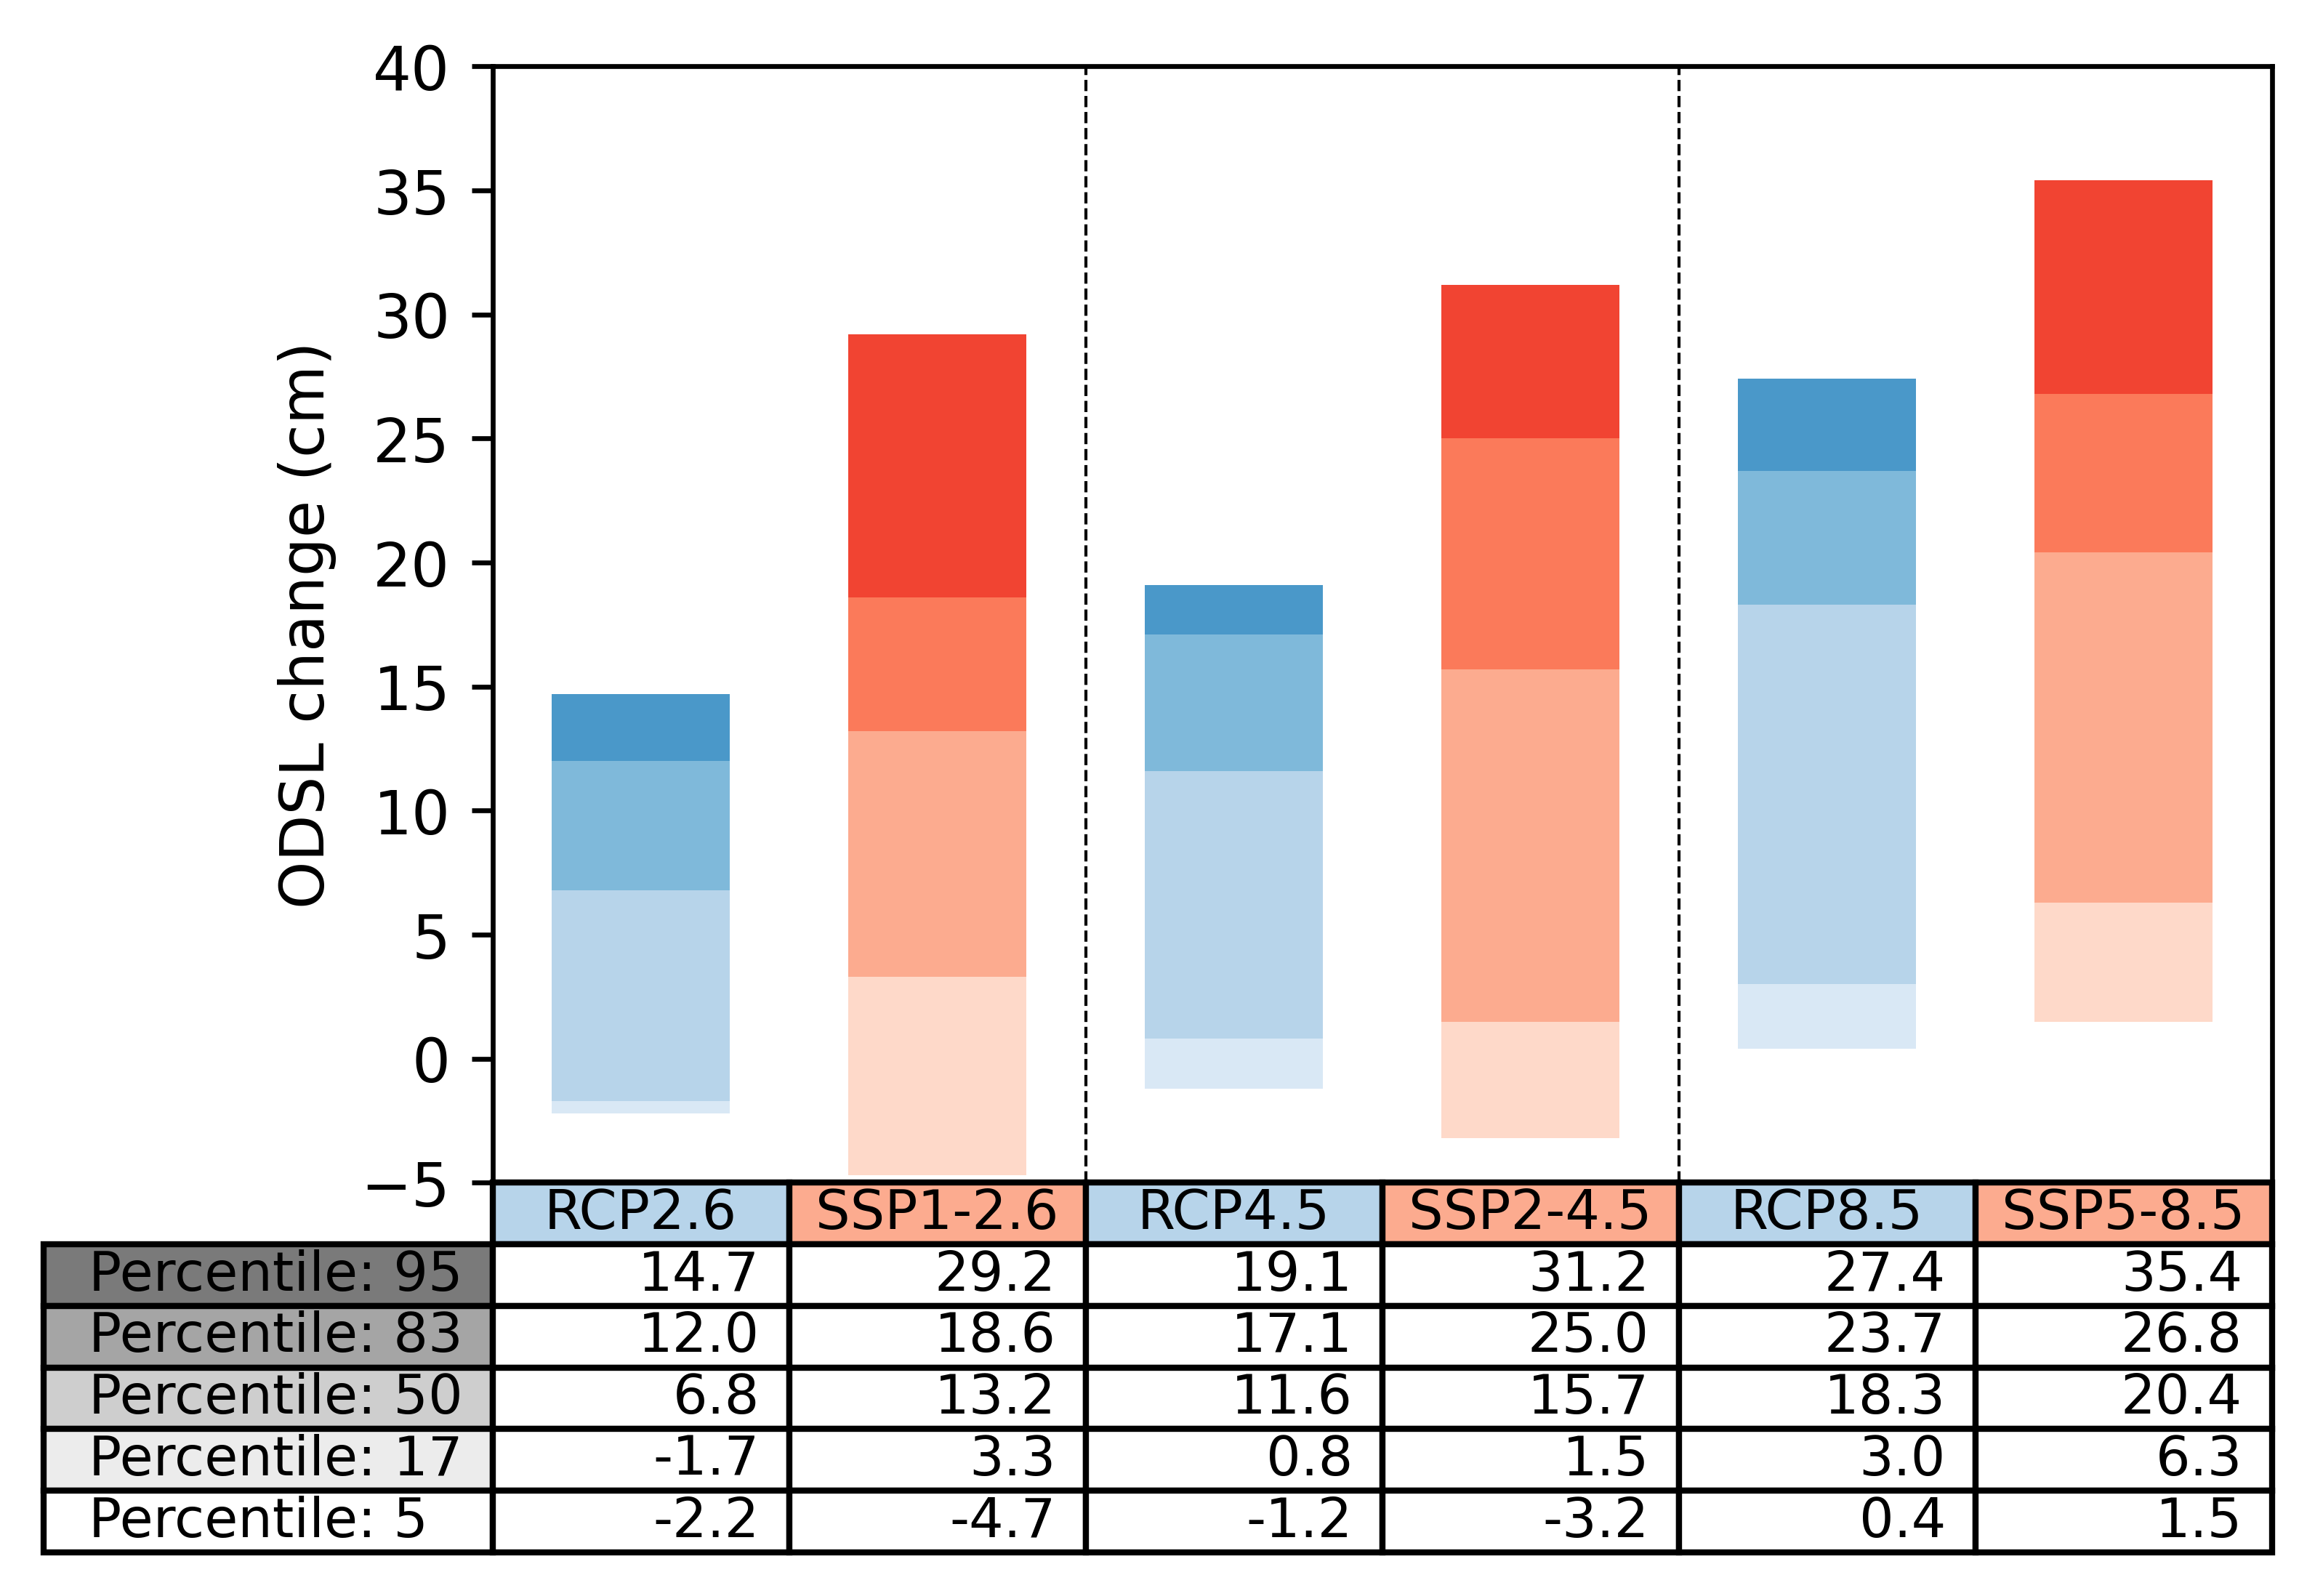

In [29]:
fig, ax = plt.subplots(1,dpi=dpi)
new_col_names =  ['RCP2.6', 'SSP1-2.6', 'RCP4.5',  
                      'SSP2-4.5', 'RCP8.5', 'SSP5-8.5'] 
Bar_ds = Bar_ds.reindex(columns = new_col_names)
    
ax = summary_fig_and_table(ax, Bar_ds, colors='alternate', vlines=True)
ax.set_ylabel('ODSL change (cm)');

plt.subplots_adjust(left=0.22, bottom=0.24)
#ax.set_title(f'CMIP5 vs. CMIP6 || {2080} - {2099}')
plt.savefig(savepath + f'perc_{start_year}-{end_year}_zos.png', dpi=dpi)

# Regional plots

In [72]:
def read_zos_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)

    return tot_ds

In [101]:
# Read zos data for both CMIP5 and CMIP6 for *2.6, *4.5, *8.5 and change reference period to 1960 - 1989
def read_zosdata(data_dir, mip, ref_start, ref_end):
    scen_dic = {'cmip5': ['rcp26', 'rcp45', 'rcp85'],
               'cmip6': ['ssp126', 'ssp245', 'ssp585']}
    zos_mip = []
    
    for idx, sce in enumerate(scen_dic[mip]):
        zos = read_zos_ds(data_dir, mip, sce)
        zos = zos - zos.sel(time=slice(ref_start, ref_end)).mean(dim='time')
        zos_mip.append(zos) 
       
    return zos_mip

In [94]:
def define_area(reg):
    '''Provides box coordinates given a region name'''
    
    if reg == 'dutch_coast':
        lon_min, lon_max = 3, 7
        lat_min, lat_max = 51, 54
    elif reg == 'north_sea':
        lon_min, lon_max = -2, 9
        lat_min, lat_max = 48, 60
    elif reg == 'knmi14_reg':
        lon_min, lon_max = -3.5, 7.5
        lat_min, lat_max = 51, 60
    
    return lon_min, lon_max, lat_min, lat_max

In [102]:
# Set reference period to 1960 - 1989
ref_start = 1900
ref_end = 1950

data_dir = '/Volumes/T7/DATA_knmi/'

# Read zos and compute for reference period
zos_mip5 = read_zosdata(data_dir, 'cmip5', ref_start, ref_end)
zos_mip6 = read_zosdata(data_dir, 'cmip6', ref_start, ref_end)

In [85]:
mods5_sces = []
mods6_sces = []

for i, sce in enumerate(['ssp126','ssp245','ssp585']):
    mods5_sces.append(select_models(CMIP5ds.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[0])
    mods6_sces.append(select_models(CMIP6ds.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[0])

In [86]:
for i, mods in enumerate(mods5_sces):
    zos_mip5[i] = zos_mip5[i].sel(model = mods)

for i, mods in enumerate(mods6_sces):
    zos_mip6[i] = zos_mip6[i].sel(model = mods)


In [87]:
# Compute multi-model mean
zos_mip5_m, zos_mip6_m = [],[]
for i in range(3):
    zos_mip5_m.append(zos_mip5[i]['CorrectedReggrided_zos'].median(dim='model'))
    zos_mip6_m.append(zos_mip6[i]['CorrectedReggrided_zos'].median(dim='model'))

In [88]:
# Concatenate data
new_dimall = xr.DataArray(['cmip5 - rcp2.6', 'cmip6 - ssp1-2.6', 'cmip5 - rcp4.5', 'cmip6 - ssp2-4.5', 
                           'cmip5 - rcp8.5', 'cmip6 - ssp5-8.5','126-diff','245-diff','585-diff'], dims='cmip', name='cmip')
concat = xr.concat([zos_mip5_m[0], zos_mip6_m[0], zos_mip5_m[1], zos_mip6_m[1], zos_mip5_m[2], zos_mip6_m[2], 
                    zos_mip6_m[0]- zos_mip5_m[0], zos_mip6_m[1]- zos_mip5_m[1], zos_mip6_m[2]- zos_mip5_m[2]], dim = new_dimall)

In [89]:
# Compute stds from concat_new 
start_year = 2081
end_year = 2101

zos_mip5_std, zos_mip6_std = [],[]
for i in range(3):
    zos_mip5_std.append(zos_mip5[i]["CorrectedReggrided_zos"].sel(time=slice(start_year+.5, end_year+.5)).mean(dim='time').std(dim='model'))
    zos_mip6_std.append(zos_mip6[i]["CorrectedReggrided_zos"].sel(time=slice(start_year+.5, end_year+.5)).mean(dim='time').std(dim='model'))

In [90]:
new_dimall = xr.DataArray(['cmip5 - rcp2.6', 'cmip6 - ssp1-2.6', 'cmip5 - rcp4.5', 'cmip6 - ssp2-4.5', 'cmip5 - rcp8.5', 'cmip6 - ssp5-8.5'], dims='cmip', name='cmip')
concat_std = xr.concat([zos_mip5_std[0], zos_mip6_std[0], zos_mip5_std[1], zos_mip6_std[1],zos_mip5_std[2], zos_mip6_std[2]], dim = new_dimall)


In [91]:
# Names of different scenarios
sce26 = ['cmip5 - rcp2.6', 'cmip6 - ssp1-2.6', '126-diff']
sce45 = ['cmip5 - rcp4.5', 'cmip6 - ssp2-4.5', '245-diff']
sce85 = ['cmip5 - rcp8.5', 'cmip6 - ssp5-8.5', '585-diff']

In [92]:
# Plot mean Global zos for CMIP5 and CMIP6 under scenario 2.6, 4.5 or 8.5 for time period start_year, end_year
start_year = 2081
end_year = 2101

# Choose scenario (sce26, sce45 or sce85) and select them from concat_new
sce = sce45
scename = 'scen45'
concat_sce = concat.loc[sce]
concat_sce_mean = concat_sce.sel(time=slice(start_year+.5, end_year+.5)).median(dim='time')

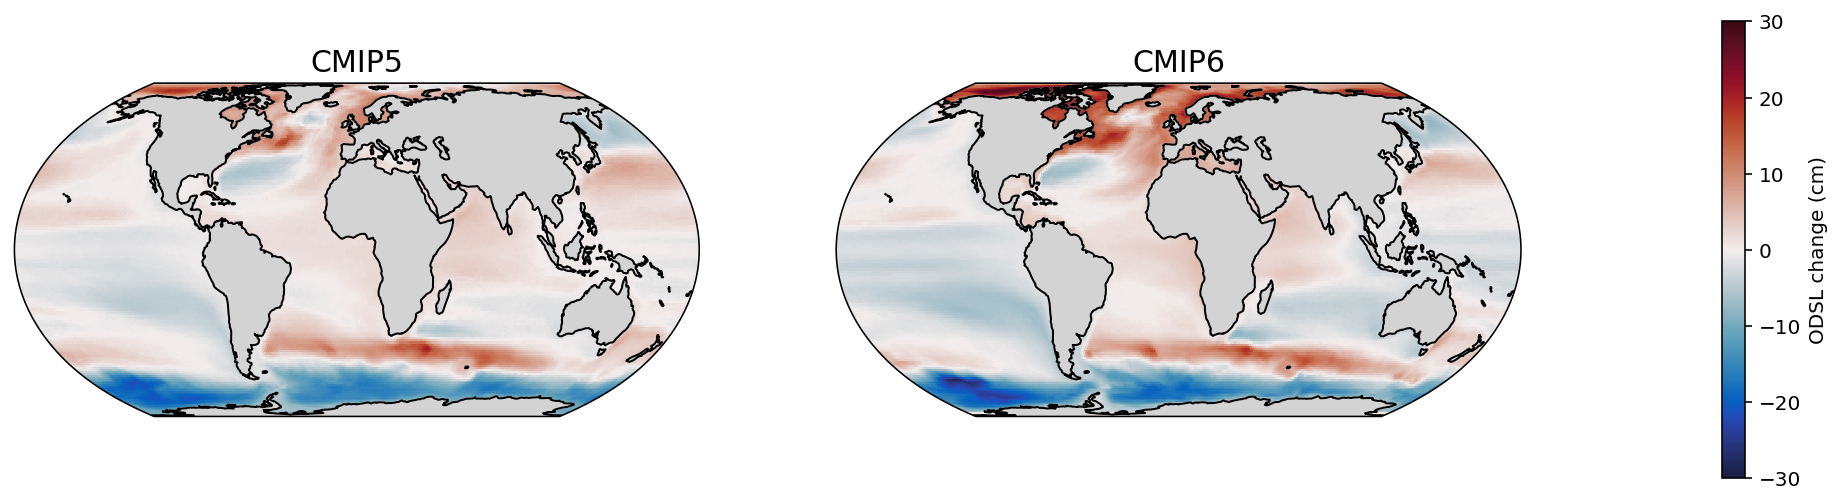

In [97]:
g = concat_sce_mean.isel(cmip=[0,1]).plot(
    col='cmip',
    col_wrap=2,
    figsize=(18,6),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.EqualEarth(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'cmo.balance',
    vmin=-30, vmax=30,
    cbar_kwargs={'orientation': 'vertical', 'label': 'ODSL change (cm)', 'pad': 0.1, 'shrink':0.7},
    robust=True
    )

titles = ['CMIP5', 'CMIP6', 'CMIP6 minus CMIP5']
for i in range(2):
    g.axes[0,i].set_title(titles[i],fontsize=15) 
    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
    g.axes[0,i].coastlines()
    
plt.savefig(savepath + f"Global_{scename}_{start_year}-{end_year}.png", dpi=dpi)

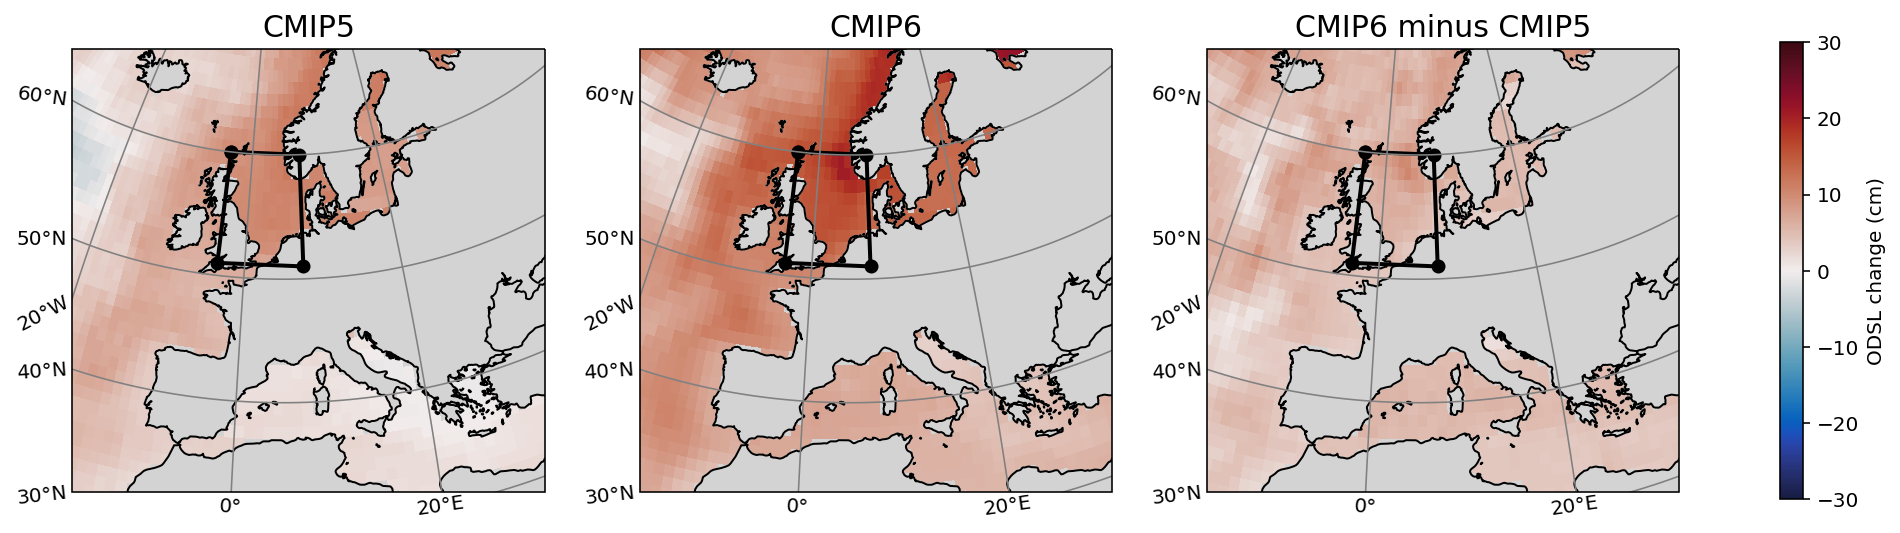

In [96]:
lon_min, lon_max, lat_min, lat_max = -15, 30, 30, 67
add_box = True

if add_box:
    lon_min_b, lon_max_b, lat_min_b, lat_max_b = define_area('knmi14_reg')
    x, y = ([lon_min_b, lon_min_b, lon_max_b, lon_max_b, lon_min_b], 
            [lat_max_b, lat_min_b, lat_min_b, lat_max_b, lat_max_b])

   
g = concat_sce_mean.plot(
    col='cmip',
    figsize=(18,6),
    subplot_kws=dict(projection=ccrs.Orthographic(5, 52), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'cmo.balance',
    vmin = -30, vmax = 30,
    cbar_kwargs = {'orientation': 'vertical', 'label': 'ODSL change (cm)', 'pad': 0.05, 'shrink':0.7},
    )

titles = ['CMIP5', 'CMIP6', 'CMIP6 minus CMIP5']
for i in range(3):
    g.axes[0,i].set_title(titles[i], fontsize=15) #Index of axis is line,column 
    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
    g.axes[0,i].coastlines()
    g.axes[0,i].set_extent([lon_min, lon_max, lat_min, lat_max])
    
    #gl.xlocator = mticker.FixedLocator([-20,0,20])

    gl = g.axes[0,i].gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.ylabels_right = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([-20,0,20])

    if add_box:
        g.axes[0,i].plot(x, y, marker='o', color = 'k', linewidth=2.0, transform=ccrs.PlateCarree())
plt.savefig(savepath + f"Regional_{scename}_{start_year}-{end_year}.png", dpi=dpi)

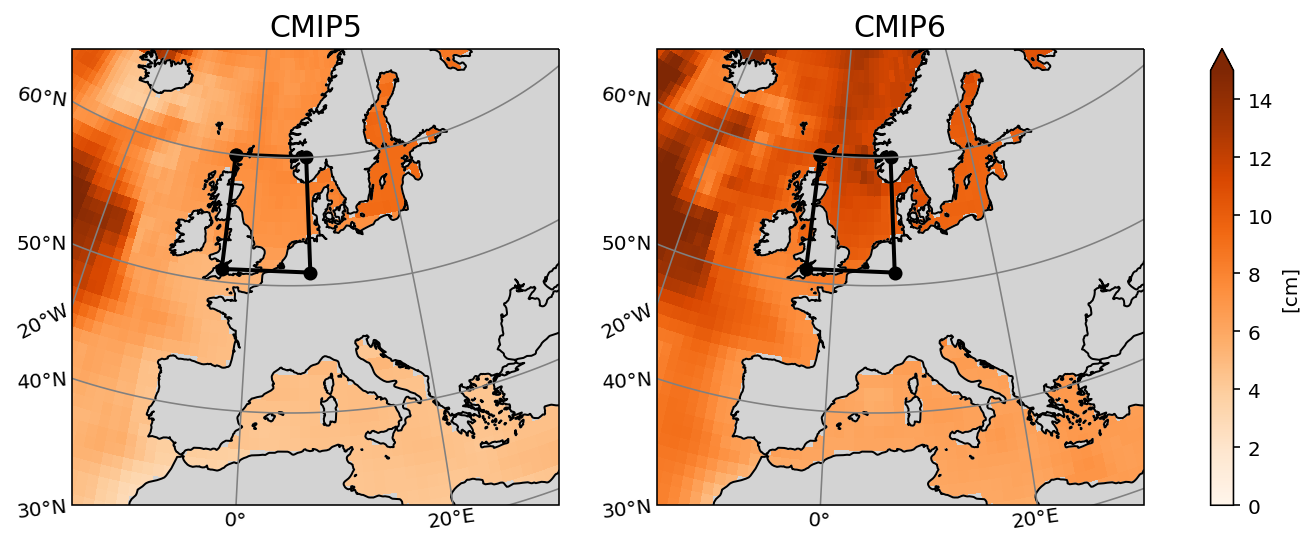

In [72]:
lon_min, lon_max, lat_min, lat_max = -15, 30, 30, 67
add_box = True

concat_sce_std = concat_std.loc[sce[0:2]]

if add_box:
    lon_min_b, lon_max_b, lat_min_b, lat_max_b = define_area('knmi14_reg')
    x, y = ([lon_min_b, lon_min_b, lon_max_b, lon_max_b, lon_min_b], 
            [lat_max_b, lat_min_b, lat_min_b, lat_max_b, lat_max_b])
    

g = concat_sce_std.plot(
    col='cmip',
    figsize=(12,6),
    subplot_kws=dict(projection=ccrs.Orthographic(5, 52), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'Oranges',
    vmin = 0, vmax = 15,
    cbar_kwargs = {'orientation': 'vertical', 'label': '[cm]', 'pad': 0.05, 'shrink':0.7},
    )

titles = ['CMIP5', 'CMIP6', 'CMIP6 minus CMIP5']
for i in range(2):
    g.axes[0,i].set_title(titles[i],fontsize=15) #Index of axis is line,column 
    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
    g.axes[0,i].coastlines()
    g.axes[0,i].set_extent([lon_min, lon_max, lat_min, lat_max])
    

    gl = g.axes[0,i].gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    gl.xlocator = mticker.FixedLocator([-20,0,20])

    if add_box:
        g.axes[0,i].plot(x, y, marker='o', color = 'k', linewidth=2.0, transform=ccrs.PlateCarree())

plt.savefig(savepath + f"Regionalstd_{scename}_{start_year}-{end_year}.png", dpi=dpi)

## AR6 ranges

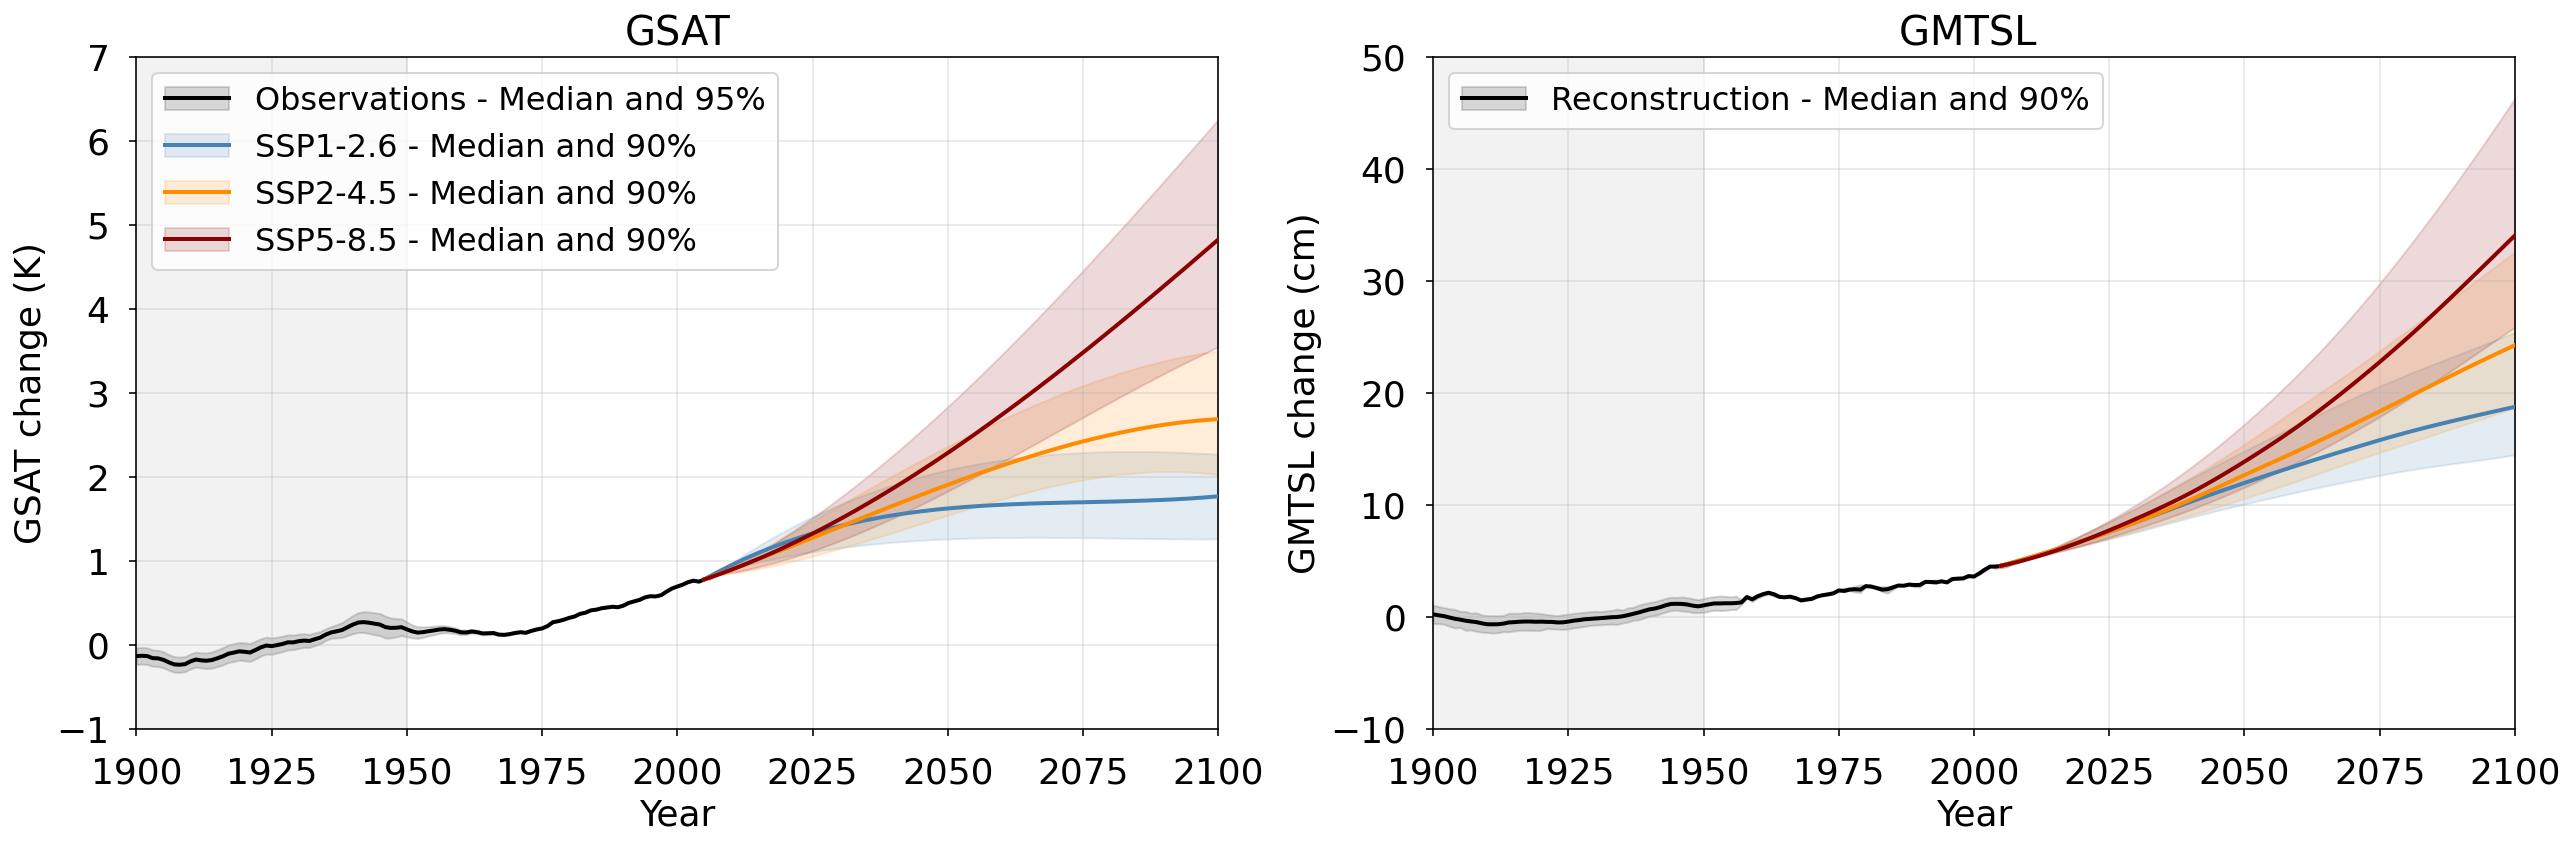

In [111]:
'''
This cell plots the Observations and AR6 ranges which we use as input for our model
'''

l = ['SSP1-2.6','SSP2-4.5','SSP5-8.5']
c_scenarios = ['steelblue', 'darkorange', 'darkred']
fig, ax = plt.subplots(1,2,figsize=(18,6),sharex=True)
#fig.suptitle('OBS + AR6 ranges',fontsize=20) # or plt.suptitle('Main title')

# Plot observations
obs, = ax[0].plot(df_low['G_50th'].loc[1900:2005],c='k',lw=2)
obss = ax[0].fill_between(df_low.loc[1900:2005].index,df_low['G_5th'].loc[1900:2005], 
                         df_low['G_95th'].loc[1900:2005],color='k',alpha=0.15, label='Observations')
ax[1].plot(df_low['z_50th'].loc[1900:2005],c='k',lw=2)
ax[1].fill_between(df_low.loc[1900:2005].index,df_low['z_5th'].loc[1900:2005],
                   df_low['z_95th'].loc[1900:2005],color='k',alpha=0.15, label='Observations')


leg, legg = [[],[],[]],[[],[],[]]
i = 0
for dfs in [df_low.loc[2005:2100],df_mid.loc[2005:2100],df_hig.loc[2005:2100]]:
    leg[i] = ax[0].plot(dfs['G_50th'], color=c_scenarios[i],zorder=10,lw=2)
    legg[i] = ax[0].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.15, color=c_scenarios[i], label=l[i])
    ax[1].plot(dfs['z_50th'], color=c_scenarios[i],zorder=10,lw=2)
    ax[1].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.15, color=c_scenarios[i])
    i = i+1
i = 0 

low, = leg[0]
mid, = leg[1]
hig, = leg[2]
loww, midd, higg = legg

ax[0].set_title('GSAT',size=20)
ax[0].set_ylabel('GSAT change (K)',size=18)
ax[0].set_ylim([-1,7])

ax[1].set_title('GMTSL ',size=20)
ax[1].set_ylabel('GMTSL change (cm)',size=18);
ax[1].set_ylim([-10,50]);

ax[0].legend([(obs, obss), (low, loww), (mid, midd), (hig, higg)], 
             [f"Observations - Median and 95%",f"SSP1-2.6 - Median and 90%",f"SSP2-4.5 - Median and 90%",f"SSP5-8.5 - Median and 90%"],
             loc=2, fontsize=16)
ax[1].legend([(obs, obss)], 
             [f"Reconstruction - Median and 90%"],
             loc=2, fontsize=16)
for axs in ax:
    axs.tick_params(axis='both', which='major', pad=10)
    axs.axvspan(1900, 1950, alpha=0.1, color='grey')
    axs.set_xlim([1900,2100])
    #axs.set_xticks([1900,1950,2000,2050,2100])
    axs.tick_params(axis='both', labelsize= 18)
    axs.set_xlabel('Year',size=18)
    axs.grid(True,alpha=0.3)
    
fig.tight_layout()
fig.savefig(savepath+'Input_AR6_ranges.png',dpi=dpi)

## LOWESS FIGURE

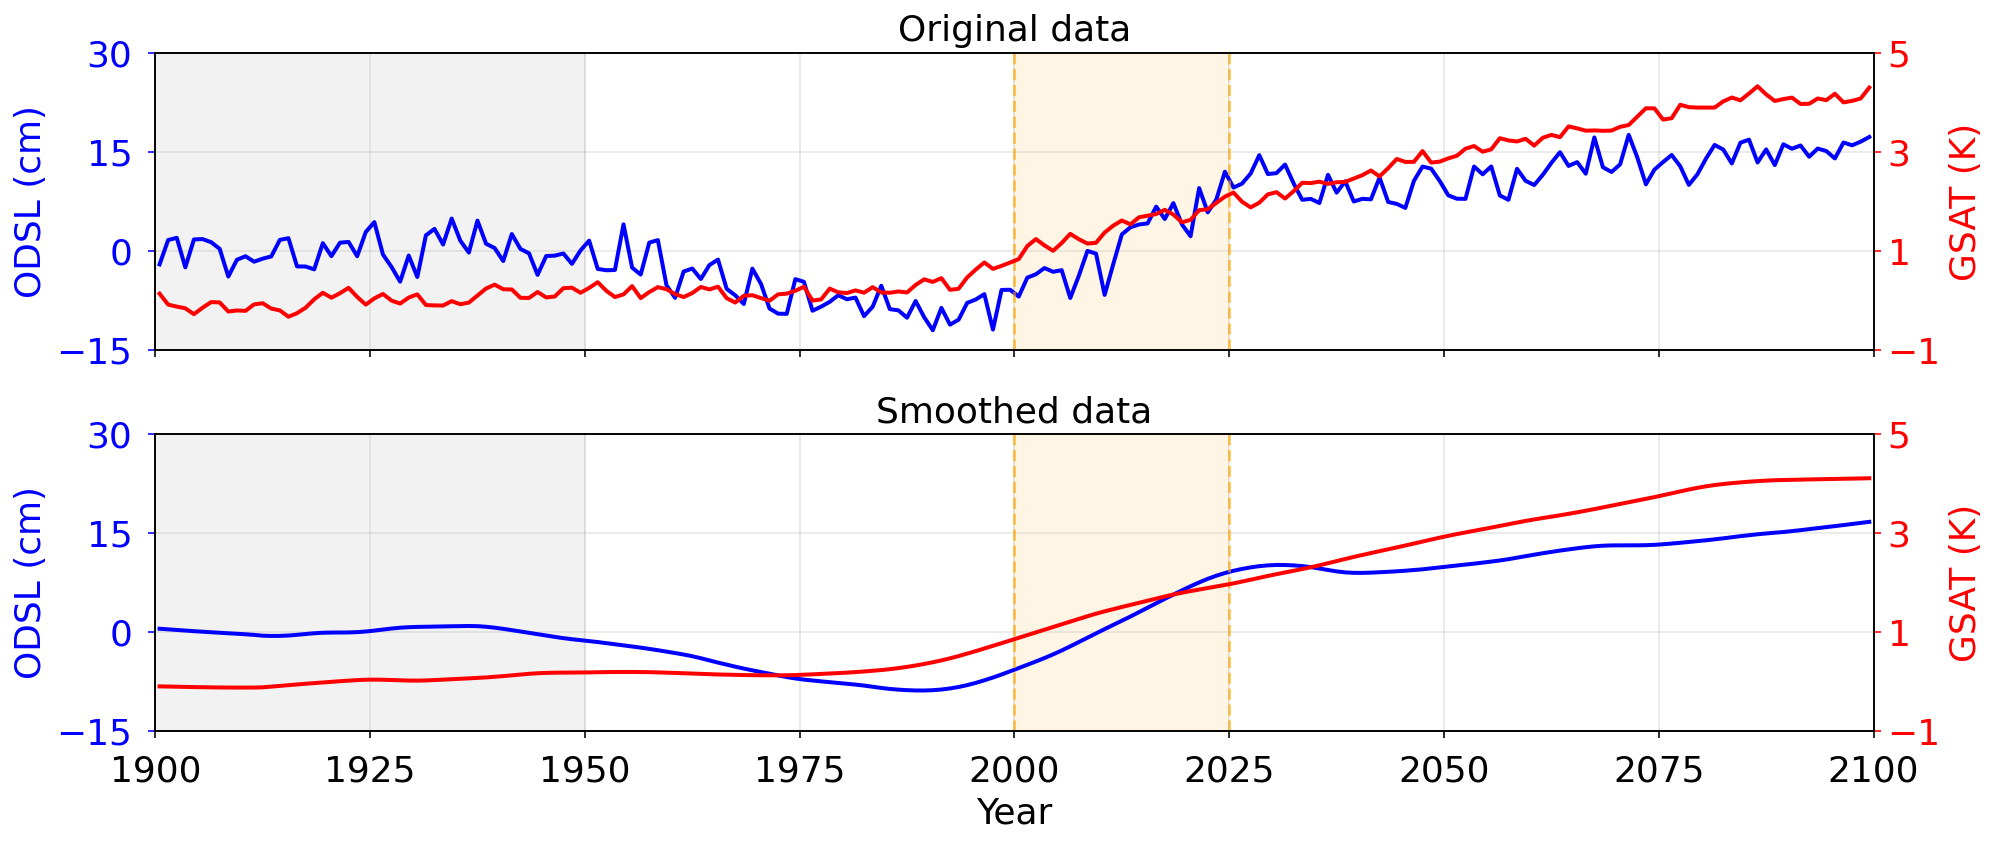

In [119]:
l = ['ODSL','GSAT']
c_scenarios = ['blue', 'red']

fig, ax = plt.subplots(2,1,figsize=(14,6),sharex=True)

# Plot observations
NoLF = CMIP6ds.sel(time=slice(1900,2100),model='CanESM5', scenario='ssp245')
LF = CMIP6ds_LF.sel(time=slice(1900,2100),model='CanESM5', scenario='ssp245')
Time = NoLF.time.values



ax[0].plot(Time, NoLF.zos.values, c='b',lw=2)

ax2=ax[0].twinx()
ax2.plot(Time, NoLF.GSAT.values, c='r',lw=2)
ax2.set_ylim([-1,5])
ax2.set_yticks(np.linspace(-1,5, 4))


ax[1].plot(Time, LF.zos.values, c='b',lw=2)

ax3=ax[1].twinx()
ax3.plot(Time, LF.GSAT.values, c='r',lw=2)
ax3.set_ylim([-1,5])
ax3.set_yticks(np.linspace(-1,5, 4))

ax[1].set_xlabel('Year',fontsize=18)


for i in range(2):
    ax[i].set_xlim([1900,2100])
    ax[i].set_ylim([-15,30])
    ax[i].set_yticks(np.linspace(-15, 30, 4))
    ax[i].tick_params(axis='x', labelsize= 18, colors='k',pad=8)
    ax[i].tick_params(axis='y', labelsize= 18, colors='b',pad=8)
    ax[i].set_ylabel('ODSL (cm)',fontsize=18,c='b')
    ax[i].grid(True,alpha=0.3);
    ax[i].axvspan(1900, 1950, alpha=0.1, color='grey')

    ax[i].axvline(2000, alpha=0.6, linestyle='dashed', color='orange')
    ax[i].axvline(2025, alpha=0.6, linestyle='dashed', color='orange')
    ax[i].axvspan(2000, 2025, alpha=0.1, color='orange')

ax[0].set_title('Original data',fontsize=18)
ax[1].set_title('Smoothed data',fontsize=18)

ax2.set_ylabel('GSAT (K)',fontsize=18,c='r')
ax3.set_ylabel('GSAT (K)',fontsize=18,c='r')

ax2.tick_params(axis='y', labelsize= 18, colors='r')
ax3.tick_params(axis='y', labelsize= 18, colors='r')


fig.tight_layout()
fig.savefig(savepath+'LOWESS_example.png',dpi=dpi)

## TEMPERATURE FIGURES

In [50]:
df_low

G_5th    G_50th    G_95th      z_5th     z_50th     z_95th
Date                                                               
1900 -0.236637 -0.136795 -0.036952  -0.622692   0.207278   1.033048
1901 -0.231938 -0.132695 -0.033451  -0.631576   0.120723   0.903380
1902 -0.235250 -0.136208 -0.037166  -0.671563   0.047457   0.799458
1903 -0.258026 -0.160644 -0.063261  -0.854562  -0.074846   0.706754
1904 -0.260009 -0.163451 -0.066894  -1.014632  -0.188805   0.650415
...        ...       ...       ...        ...        ...        ...
2096  1.258626  1.746254  2.280881  14.155101  18.306375  24.621503
2097  1.258626  1.750254  2.277881  14.226101  18.415375  24.812503
2098  1.258626  1.755254  2.274881  14.299101  18.524375  25.005503
2099  1.259626  1.760254  2.270881  14.375101  18.634375  25.200503
2100  1.259626  1.766254  2.267881  14.453101  18.744375  25.397503

[201 rows x 6 columns]

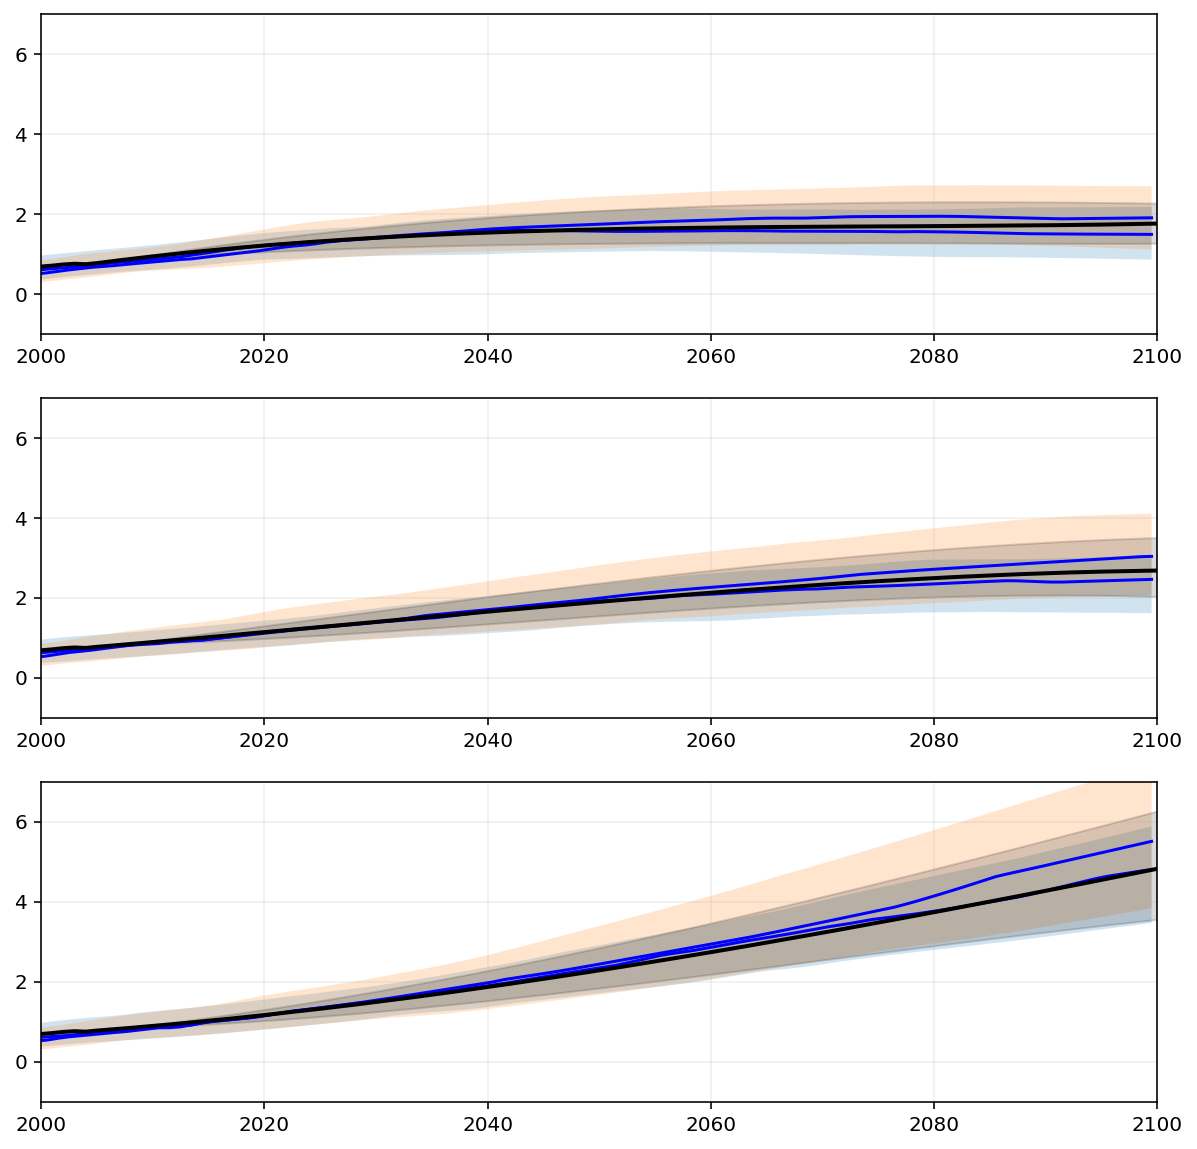

In [52]:
''' Construct figure with different temperatures - CMIP5 CMIP6 AR6 for different scenarios'''
scess = ['ssp126','ssp245','ssp585']
dfs = [df_low,df_mid,df_hig]
fig,ax = plt.subplots(3,1,figsize=(10,10))

for i in range(3):
    ds5 = select_models(data_5C.sel(scenario=scess[i]), 'GSAT', 'GSAT', 'zos', 'model')[1]
    ds6 = select_models(data_6C.sel(scenario=scess[i]), 'GSAT', 'GSAT', 'zos', 'model')[1]
    
    ax[i].plot(ds5.time.values,ds5.median(dim='model').GSAT.values,c='b')
    ax[i].fill_between(ds5.time.values,np.percentile(ds5.GSAT.values,5,axis=0),
                    np.percentile(ds5.GSAT.values,95,axis=0),alpha=0.2)
    ax[i].plot(ds6.time.values,ds6.median(dim='model').GSAT.values,c='b')
    ax[i].fill_between(ds6.time.values,np.percentile(ds6.GSAT.values,5,axis=0),
                    np.percentile(ds6.GSAT.values,95,axis=0),alpha=0.2)
    
    ax[i].plot(dfs[i]['G_50th'], color='k',zorder=10,lw=2)
    ax[i].fill_between(dfs[i].index,dfs[i]['G_5th'],dfs[i]['G_95th'],alpha=0.15, color='k')
    ax[i].set_xlim([2000,2100])
    ax[i].set_ylim([-1,7])
    ax[i].grid(True,alpha=0.2)
    
    
    
    

   # plt.plot(ds.sel(scenario=scess[i]).GSAT.median(dim='model').values,c='r')
   # plt.plot(np.median(AR6ds[i],axis=1),c='k')

In [ ]:
'''
This cell plots the Observations and AR6 ranges which we use as input for our model
'''

l = ['SSP1-2.6','SSP2-4.5','SSP5-8.5']
c_scenarios = ['steelblue', 'darkorange', 'darkred']
fig, ax = plt.subplots(1,2,figsize=(18,6),sharex=True)
#fig.suptitle('OBS + AR6 ranges',fontsize=20) # or plt.suptitle('Main title')

# Plot observations
obs, = ax[0].plot(df_low['G_50th'].loc[1900:2005],c='k',lw=2)
obss = ax[0].fill_between(df_low.loc[1900:2005].index,df_low['G_5th'].loc[1900:2005], 
                         df_low['G_95th'].loc[1900:2005],color='k',alpha=0.15, label='Observations')
ax[1].plot(df_low['z_50th'].loc[1900:2005],c='k',lw=2)
ax[1].fill_between(df_low.loc[1900:2005].index,df_low['z_5th'].loc[1900:2005],
                   df_low['z_95th'].loc[1900:2005],color='k',alpha=0.15, label='Observations')


leg, legg = [[],[],[]],[[],[],[]]
i = 0
for dfs in [df_low.loc[2005:2100],df_mid.loc[2005:2100],df_hig.loc[2005:2100]]:
    leg[i] = ax[0].plot(dfs['G_50th'], color=c_scenarios[i],zorder=10,lw=2)
    legg[i] = ax[0].fill_between(dfs.index,dfs['G_5th'],dfs['G_95th'],alpha=0.15, color=c_scenarios[i], label=l[i])
    ax[1].plot(dfs['z_50th'], color=c_scenarios[i],zorder=10,lw=2)
    ax[1].fill_between(dfs.index,dfs['z_5th'],dfs['z_95th'],alpha=0.15, color=c_scenarios[i])
    i = i+1
i = 0 

low, = leg[0]
mid, = leg[1]
hig, = leg[2]
loww, midd, higg = legg

ax[0].set_title('GSAT',size=20)
ax[0].set_xlabel('Year',size=18)
ax[0].set_ylabel('GSAT change (K)',size=18)

ax[0].tick_params(axis='x', labelsize= 18)
ax[0].tick_params(axis='y', labelsize= 18)
ax[0].set_xlim([1900,2100])
ax[0].set_ylim([-1,7])
ax[0].grid(True,alpha=0.3)

ax[1].set_title('GSSL ',size=20)
ax[1].set_xlabel('Year',size=18)
ax[1].set_ylabel('GSSL change (cm)',size=18);

ax[1].tick_params(axis='x', labelsize= 18)
ax[1].tick_params(axis='y', labelsize= 18)
ax[1].set_xlim([1900,2100])
ax[1].set_ylim([-10,50]);
ax[1].grid(True,alpha=0.3);


ax[0].legend([(obs, obss), (low, loww), (mid, midd), (hig, higg)], 
             [f"Observations",f"SSP1-2.6",f"SSP2-4.5",f"SSP5-8.5"],
             loc=2, fontsize=16)
ax[0].axvspan(1900, 1950, alpha=0.1, color='grey')
ax[1].axvspan(1900, 1950, alpha=0.1, color='grey')

fig.tight_layout()
fig.savefig(savepath+'Input_AR6_ranges.png',dpi=dpi)